# **Vaccine Effectiveness** in Fortaleza - **Results**

**Author**: Higor S. Monteiro<br>
**Date**: 2022/05/24

The main goal of this notebook is to obtain the summaries and figures to plot the storyline of the final manuscript.

The storyline is supposed to be divided by the following topics:
1. **Covid-19 contextualization in Fortaleza**.
    - **Outcomes**: Deaths, Hospitalizations and ICU admissions.
    - **Vaccination**: Vaccine coverage of first and second dose for each vaccine. 
2. **Cohort details**.
3. **Matching details and summaries**.
4. **Survival analysis summaries: Kaplan-Meier curves**.
5. **Vaccine effectiveness**.
    - Stratifications by `age`, `sex` and `HDI`.

# **Lib**

In [2]:
# -- Config
import sys
sys.path.append("..")

# -- Essential
import os
import pandas as pd
import numpy as np
import datetime as dt
from collections import defaultdict
import lib.utils as utils
from src.FigUtils import FigUtils

# -- Filter warnings
import warnings
warnings.filterwarnings("ignore")

# -- Plotting 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from IPython.display import Image
%matplotlib inline

# **Config**

## **Paths**

In [3]:
base_path = os.path.join(os.environ["USERPROFILE"], "Documents")
parquet_folder = os.path.join(base_path, "data", "PARQUET_TRANSFORMED")
project_folder = os.path.join(base_path, "projects", "vaccine-eff-fortaleza")

fig_folder = os.path.join(project_folder, "output", "figs", "Fig2022_May")
schema_folder = os.path.join(project_folder, "output", "data")
pareamento_folder = os.path.join(project_folder, "output", "PAREAMENTO")
fig_pres = os.path.join(project_folder, "output", "figs", "meeting_jun6_2022")

fschema = pd.read_parquet(os.path.join(schema_folder, "SCHEMA_21JAN2021_31AUG2021.parquet"))

In [4]:
# -- Pop 2021
pop2021 = pd.read_excel(os.path.join(base_path, "data", "pop_2021.xlsx"))

## **Utils**

Which parameters are necessary to identify a plot?

1. Test prefix
2. HDI index
3. Vaccine
4. Dose
5. Cohort period
6. Seed number 
7. Event
8. Day of risk

#### **Open files**: **KM** and **VE** curves

In [5]:
def open_km(vaccine, test_prefix, hdi_index, dose, cohort_str, event, day_risk, seed, strat=None):
    '''
        Open a file regarding to a Kaplan-Meier curve.
        
        Here we identify a curve by: the vaccine, the prefix for the experiment used, HDI stratification used,
        dose to consider, cohort string related to the start and end of cohort, which event to consider, minimum
        number of days in risk to consider, and seed of the running. 
    '''
    fname = os.path.join(pareamento_folder, vaccine, f"{test_prefix}_HDI_{hdi_index}_{cohort_str}", "SURVIVAL", f"SEED{seed}", f"KM_events_{dose}_{event}_DAY{day_risk}.xlsx")
    hdf = pd.read_excel(fname, sheet_name=strat)
    return hdf

def open_ve(vaccine, test_prefix, hdi_index, dose, cohort_str, event, day_risk, seed, strat=None):
    '''
        Open a file regarding to a Vaccine Effectiveness curve.
        
        Here we identify a curve by: the vaccine, the prefix for the experiment used, HDI stratification used,
        dose to consider, cohort string related to the start and end of cohort, which event to consider, minimum
        number of days in risk to consider, and seed of the running.
    '''
    fname = os.path.join(pareamento_folder, vaccine, f"{test_prefix}_HDI_{hdi_index}_{cohort_str}", "SURVIVAL", f"SEED{seed}", f"VE_{dose}_{event}_DAY{day_risk}.xlsx")
    hdf = pd.read_excel(fname, sheet_name=strat)
    return hdf

#### **Open files**: Matched pairs

In [6]:
def get_pairs(vaccine, test_prefix, hdi_index, dose, cohort_str, day_risk, seed):
    '''
        Open a file containing the matched pairs' CPFs.
        
        Here we identify an 'experiment' by: the vaccine, the prefix for the experiment used, HDI stratification used,
        dose to consider, cohort string related to the start and end of cohort, which event to consider, minimum
        number of days in risk to consider, and random number seed of the experiment. 
    '''
    fname = os.path.join(pareamento_folder, vaccine, f"{test_prefix}_HDI_{hdi_index}_{cohort_str}", f"PAREADOS_CPF_{dose}_DAY{day_risk}_{seed}.parquet")
    df = pd.read_parquet(fname)
    return df

def get_pairs_events(vaccine, test_prefix, hdi_index, dose, cohort_str, day_risk, seed):
    '''
        Open a file containing the matched pairs' CPFs together with information on events.
        
        Here we identify an 'experiment' by: the vaccine, the prefix for the experiment used, HDI stratification used,
        dose to consider, cohort string related to the start and end of cohort, which event to consider, minimum
        number of days in risk to consider, and random number seed of the experiment. 
    '''
    fname = os.path.join(pareamento_folder, vaccine, f"{test_prefix}_HDI_{hdi_index}_{cohort_str}", f"PAREADOS_COM_INTERVALOS_{dose}_OBITO_DAY{day_risk}_{seed}.parquet")
    df = pd.read_parquet(fname)
    return df

#### **Open survival file**

In [7]:
def open_survival(vaccine, test_prefix, hdi_index, dose, cohort_str, event, day_risk, seed):
    '''
    
    '''
    fname = os.path.join(pareamento_folder, vaccine, f"{test_prefix}_HDI_{hdi_index}_{cohort_str}", "SURVIVAL", f"SURVIVAL_{dose}_{event}_DAY{day_risk}_{seed}.parquet")
    df = pd.read_parquet(fname)
    return df

#### **Pretty plot**: **KM** curves

In [8]:
def pprint_km(vaccine, test_prefix, hdi_index, dose, cohort_str, event, day_risk, seed, strat=None):
    '''
    
    '''
    fig, ax = plt.subplots(1,figsize=(7,5))
    ax.tick_params(direction="in", width=1.5, top=True, right=True, labelsize=11)
    ax.set_xlim(0, 90)
    ax.set_xticks([0, 14, 28, 42, 56, 70, 84])
    ax.grid(alpha=0.2)
    
    ax.text(-0.25, -0.12, "At risk", fontsize=11, weight="bold", transform=ax.transAxes)
    ax.text(-0.25, -0.18, "Unvaccinated", fontsize=11, transform=ax.transAxes)
    ax.text(-0.25, -0.23, "Vaccinated", fontsize=11, transform=ax.transAxes)
    
    ax.text(-0.25, -0.31, "Cumulative No. Outcomes", fontsize=11, weight="bold", transform=ax.transAxes)
    ax.text(-0.25, -0.37, "Unvaccinated", fontsize=11, transform=ax.transAxes)
    ax.text(-0.25, -0.42, "Vaccinated", fontsize=11, transform=ax.transAxes)
    
    event_hash = {
        "OBITO": "DEATH", "HOSPITAL": "HOSPITALIZATION", "UTI": "ADMISSION TO ICU",
    }
    
    ax.text(-0.25, 1.2, f"Kaplan-Meier curves for dose {dose} ({vaccine}) - {event_hash[event]}", fontsize=13, weight="bold", transform=ax.transAxes)
    hdi_hash = {
        0: "[0.0-1.0]", 1: "[0.00-0.25-0.35-0.50-1.00]", 2: "[0.000-0.499-0.599-0.699-0.799-1.000]"
    }
    ax.text(-0.25, 1.12, f"HDI stratification for matching: {hdi_hash[hdi_index]}", fontsize=11, transform=ax.transAxes)
    
    # --> KM DATA
    if strat is None:
        strat = "KM_DOSE"
    df = open_km(vaccine, test_prefix, hdi_index, dose, cohort_str, event, day_risk, seed, strat=f"{strat}")
    # --> Number of at risk and number of outcomes
    caso_risk_cumm = df["at_risk(caso)"]
    controle_risk_cumm = df["at_risk(controle)"]
    caso_outcome_cumm = df["observed(caso)"].cumsum()
    controle_outcome_cumm = df["observed(controle)"].cumsum()
    
    start = -0.005
    step = 0.155
    for t in [0, 14, 28, 42, 56, 70, 84]:
        ax.text(start, -0.18, int(controle_risk_cumm.loc[t]),  transform=ax.transAxes)
        ax.text(start, -0.23, int(caso_risk_cumm.loc[t]),  transform=ax.transAxes)
        ax.text(start, -0.37, int(controle_outcome_cumm.loc[t]),  transform=ax.transAxes)
        ax.text(start, -0.42, int(caso_outcome_cumm.loc[t]),  transform=ax.transAxes)
        start += step
        
    for j in ['top', 'bottom', 'left', 'right']:
        ax.spines[j].set_linewidth(1.5)
    ax.set_xlabel("Days", weight="bold", fontsize=12)
    ax.set_ylabel("Cumulative Incidence \n(Kaplan-Meier)", weight="bold", fontsize=12)
        
    # Plot the Kaplan-Meier 
    sns.lineplot(x="t", y="KM(caso)", data=df, ax=ax, color="tab:blue", label="Vaccinated", lw=1.5)
    ax.fill_between(df["t"], df["KM_lower_0.95(caso)"], df["KM_upper_0.95(caso)"], color="tab:blue", alpha=0.2)
    sns.lineplot(x="t", y="KM(controle)", data=df, ax=ax, color="tab:orange", label="Unvaccinated", lw=1.5)
    ax.fill_between(df["t"], df["KM_lower_0.95(controle)"], df["KM_upper_0.95(controle)"], color="tab:orange", alpha=0.2)
    ax.legend(prop={'size':13}, loc=2)
    return fig
    
def pprint_km_d1(vaccine, test_prefix, hdi_index, cohort_str, event, day_risk, seed, strat=None):
    '''
    
    '''
    dose = "D1"
    fig, ax = plt.subplots(1,figsize=(7,5))
    ax.tick_params(direction="in", width=1.5, top=True, right=True, labelsize=11)
    ax.set_xlim(0, 60)
    ax.set_xticks([0, 14, 28, 42, 56])
    ax.grid(alpha=0.2)
    
    ax.text(-0.25, -0.12, "At risk", fontsize=11, weight="bold", transform=ax.transAxes)
    ax.text(-0.25, -0.18, "Unvaccinated", fontsize=11, transform=ax.transAxes)
    ax.text(-0.25, -0.23, "Vaccinated", fontsize=11, transform=ax.transAxes)
    
    ax.text(-0.25, -0.31, "Cumulative No. Outcomes", fontsize=11, weight="bold", transform=ax.transAxes)
    ax.text(-0.25, -0.37, "Unvaccinated", fontsize=11, transform=ax.transAxes)
    ax.text(-0.25, -0.42, "Vaccinated", fontsize=11, transform=ax.transAxes)
    
    ax.text(-0.25, 1.2, f"Kaplan-Meier curves for dose {dose} ({vaccine}) - {event}", fontsize=13, weight="bold", transform=ax.transAxes)
    hdi_hash = {
        0: "[0.0-1.0]", 1: "[0.00-0.25-0.35-0.50-1.00]", 2: "[0.000-0.499-0.599-0.699-0.799-1.000]"
    }
    ax.text(-0.25, 1.12, f"HDI stratification for matching: {hdi_hash[hdi_index]}", fontsize=11, transform=ax.transAxes)
    
    # --> KM DATA
    if strat is None:
        strat = "KM_DOSE"
    df = open_km(vaccine, test_prefix, hdi_index, dose, cohort_str, event, day_risk, seed, strat=f"{strat}")
    # --> Number of at risk and number of outcomes
    caso_risk_cumm = df["at_risk(caso)"]
    controle_risk_cumm = df["at_risk(controle)"]
    caso_outcome_cumm = df["observed(caso)"].cumsum()
    controle_outcome_cumm = df["observed(controle)"].cumsum()
    
    start = -0.005
    step = 0.232
    for t in [0, 14, 28, 42, 56]:
        ax.text(start, -0.18, int(controle_risk_cumm.loc[t]),  transform=ax.transAxes)
        ax.text(start, -0.23, int(caso_risk_cumm.loc[t]),  transform=ax.transAxes)
        ax.text(start, -0.37, int(controle_outcome_cumm.loc[t]),  transform=ax.transAxes)
        ax.text(start, -0.42, int(caso_outcome_cumm.loc[t]),  transform=ax.transAxes)
        start += step
        
    for j in ['top', 'bottom', 'left', 'right']:
        ax.spines[j].set_linewidth(1.5)
    ax.set_xlabel("Days", weight="bold", fontsize=12)
    ax.set_ylabel("Cumulative Incidence \n(Kaplan-Meier)", weight="bold", fontsize=12)
        
    # Plot the Kaplan-Meier 
    sns.lineplot(x="t", y="KM(caso)", data=df, ax=ax, color="tab:blue", label="Vaccinated", lw=1.5)
    ax.fill_between(df["t"], df["KM_lower_0.95(caso)"], df["KM_upper_0.95(caso)"], color="tab:blue", alpha=0.2)
    sns.lineplot(x="t", y="KM(controle)", data=df, ax=ax, color="tab:orange", label="Unvaccinated", lw=1.5)
    ax.fill_between(df["t"], df["KM_lower_0.95(controle)"], df["KM_upper_0.95(controle)"], color="tab:orange", alpha=0.2)
    ax.legend(prop={'size':13}, loc=2)

#### **Pretty plot**: **VE** curves

In [9]:
def pprint_ve(vaccine, test_prefix, hdi_index, dose, cohort_str, event, day_risk, seed, strat=None, plot_days=9):
    '''
    
    '''
    event_hash = {
        "OBITO": "DEATH", "HOSPITAL": "HOSPITALIZATION", "UTI": "ADMISSION TO ICU",
    }
    
    fig, ax = plt.subplots(1,figsize=(7,5))
    ax.tick_params(direction="in", width=1.5, top=True, right=True, labelsize=12)
    ax.set_xlim(0, 90)
    ax.set_xticks([0,14,28,42, 56, 70, 84])
    ax.grid(alpha=0.2)
    
    ax.text(-0.25, -0.18, "Cumulative No. Outcomes", fontsize=11, weight="bold", transform=ax.transAxes)
    ax.text(-0.25, -0.24, "Unvaccinated", fontsize=11, transform=ax.transAxes)
    ax.text(-0.25, -0.29, "Vaccinated", fontsize=11, transform=ax.transAxes)
    
    ax.text(-0.25, 1.2, f"Effectiveness curve for dose {dose} ({vaccine}) - {event_hash[event]}", fontsize=13, weight="bold", transform=ax.transAxes)
    hdi_hash = {
        0: "[0.0-1.0]", 1: "[0.00-0.25-0.35-0.50-1.00]", 2: "[0.000-0.499-0.599-0.699-0.799-1.000]"
    }
    ax.text(-0.25, 1.12, f"HDI stratification for matching: {hdi_hash[hdi_index]}", fontsize=11, transform=ax.transAxes)
    
    # --> VE DATA
    if strat is None:
        strat = "DOSE"
    df = open_ve(vaccine, test_prefix, hdi_index, dose, cohort_str, event, day_risk, seed, strat=f"{strat}")
    ve, ve_lower, ve_upper = df["VE_original"], df["VE_lower_0.95"], df["VE_upper_0.95"]
    print(ve.loc[90])
    
    for j in ['top', 'bottom', 'left', 'right']:
        ax.spines[j].set_linewidth(1.5)
    ax.set_ylim([0,1])
    if dose=="D1":
        ax.set_ylim([-1,1])
    ax.set_xlabel("Days", weight="bold", fontsize=12)
    ax.set_ylabel("1 - Risk Ratio \n(Vaccine Effectiveness)", weight="bold", fontsize=12)
    
    # --> Outcomes
    # --> KM DATA
    if strat is None:
        strat = "DOSE"
        df1 = open_km(vaccine, test_prefix, hdi_index, dose, cohort_str, event, day_risk, seed, strat=f"KM_{strat}")
    elif strat=="HDI_000_050" or strat=="HDI_050_1":
        df1 = open_km(vaccine, test_prefix, hdi_index, dose, cohort_str, event, day_risk, seed, strat=f"{strat}")
    else:
        df1 = open_km(vaccine, test_prefix, hdi_index, dose, cohort_str, event, day_risk, seed, strat=f"KM_{strat}")
    #df1 = open_km(vaccine, test_prefix, hdi_index, dose, cohort_str, event, day_risk, seed, strat=f"KM_{strat}")
    caso_risk_cumm, controle_risk_cumm = df1["at_risk(caso)"], df1["at_risk(controle)"]
    caso_outcome_cumm, controle_outcome_cumm = df1["observed(caso)"].cumsum(), df1["observed(controle)"].cumsum()
    
    start = -0.005
    step = 0.155
    for t in [0, 14, 28, 42, 56, 70, 84]:
        ax.text(start, -0.24, int(controle_outcome_cumm.loc[t]),  transform=ax.transAxes)
        ax.text(start, -0.29, int(caso_outcome_cumm.loc[t]),  transform=ax.transAxes)
        start += step
    
    sns.lineplot(x="t", y="VE_original", data=df.loc[day_risk+plot_days:], ax=ax, color="tab:blue", lw=1.5)
    #sns.lineplot(x="t", y="VE", data=df.loc[day_risk+plot_days:], ax=ax, color="black", alpha=0.1, lw=1.5)
    ax.fill_between(df["t"].loc[day_risk+plot_days:], df["VE_lower_0.95"].loc[day_risk+plot_days:], df["VE_upper_0.95"].loc[day_risk+plot_days:], color="tab:blue", alpha=0.2)
    return fig
    
def pprint_ve_d1(vaccine, test_prefix, hdi_index, cohort_str, event, day_risk, seed, strat=None, plot_days=9):
    '''
    
    '''
    dose = "D1"
    fig, ax = plt.subplots(1,figsize=(7,5))
    ax.tick_params(direction="in", width=1.5, top=True, right=True, labelsize=12)
    ax.set_xlim(0, 60)
    ax.set_xticks([0, 14, 28, 42, 56])
    ax.grid(alpha=0.2)
    
    ax.text(-0.25, -0.18, "Cumulative No. Outcomes", fontsize=11, weight="bold", transform=ax.transAxes)
    ax.text(-0.25, -0.24, "Unvaccinated", fontsize=11, transform=ax.transAxes)
    ax.text(-0.25, -0.29, "Vaccinated", fontsize=11, transform=ax.transAxes)
    
    ax.text(-0.25, 1.2, f"Effectiveness curve for dose {dose} ({vaccine}) - {event}", fontsize=13, weight="bold", transform=ax.transAxes)
    hdi_hash = {
        0: "[0.0-1.0]", 1: "[0.00-0.25-0.35-0.50-1.00]", 2: "[0.000-0.499-0.599-0.699-0.799-1.000]",
    }
    ax.text(-0.25, 1.12, f"HDI stratification for matching: {hdi_hash[hdi_index]}", fontsize=11, transform=ax.transAxes)
    
    # --> VE DATA
    if strat is None:
        strat = "DOSE"
    df = open_ve(vaccine, test_prefix, hdi_index, dose, cohort_str, event, day_risk, seed, strat=f"{strat}")
    ve, ve_lower, ve_upper = df["VE_original"], df["VE_lower_0.95"], df["VE_upper_0.95"]
    
    for j in ['top', 'bottom', 'left', 'right']:
        ax.spines[j].set_linewidth(1.5)
    ax.set_ylim([0,1])
    if dose=="D1":
        ax.set_ylim([-1,1])
    ax.set_xlabel("Days", weight="bold", fontsize=12)
    ax.set_ylabel("1 - Risk Ratio \n(Vaccine Effectiveness)", weight="bold", fontsize=12)
    
    # --> Outcomes
    # --> KM DATA
    if strat is None:
        strat = "KM_DOSE"
    df1 = open_km(vaccine, test_prefix, hdi_index, dose, cohort_str, event, day_risk, seed, strat=f"KM_{strat}")
    caso_risk_cumm, controle_risk_cumm = df1["at_risk(caso)"], df1["at_risk(controle)"]
    caso_outcome_cumm, controle_outcome_cumm = df1["observed(caso)"].cumsum(), df1["observed(controle)"].cumsum()
    
    start = -0.005
    step = 0.232
    for t in [0, 14, 28, 42, 56]:
        ax.text(start, -0.24, int(controle_outcome_cumm.loc[t]),  transform=ax.transAxes)
        ax.text(start, -0.29, int(caso_outcome_cumm.loc[t]),  transform=ax.transAxes)
        start += step
    
    sns.lineplot(x="t", y="VE_original", data=df.loc[day_risk+plot_days:], ax=ax, color="tab:blue", lw=1.5)
    ax.fill_between(df["t"].loc[day_risk+plot_days:], df["VE_lower_0.95"].loc[day_risk+plot_days:], df["VE_upper_0.95"].loc[day_risk+plot_days:], color="tab:blue", alpha=0.2)

In [204]:
def ve_mean(vaccine, test_prefix, hdi_index, dose, cohort_str, event, day_risk, strat="DOSE", plot_days=9):
    '''
    
    '''
    seeds = [1,2,3,4,5,6,7,8,9,10]
    ve_dfs = []
    for seed in seeds:
        cur_df = open_ve(vaccine, test_prefix, hdi_index, dose, cohort_str, event, day_risk, seed, strat=f"{strat}")
        cur_df = cur_df.set_index("t")
        ve_dfs.append(cur_df["VE_original"])
    ve_seeds = pd.concat(ve_dfs, axis=1)
    mean_df = ve_seeds.mean(axis=1)
    std_df = ve_seeds.std(axis=1)
    sem_df = ve_seeds.sem(axis=1)
    ve_seeds['VE_mean'] = mean_df
    ve_seeds['std'] = std_df
    ve_seeds['SE'] = sem_df
    ve_seeds['VE_mean_lower'] = ve_seeds["VE_mean"]-ve_seeds["SE"]
    ve_seeds['VE_mean_upper'] = ve_seeds["VE_mean"]+ve_seeds["SE"]
    ve_seeds['VE_mean_lower_std'] = ve_seeds["VE_mean"]-(ve_seeds["std"]/2)
    ve_seeds['VE_mean_upper_std'] = ve_seeds["VE_mean"]+(ve_seeds["std"]/2)
    ve_seeds = ve_seeds.reset_index()
    print(ve_seeds['VE_mean'].loc[90])
    return ve_seeds

def stats_error_ve(vaccine, test_prefix, hdi_index, dose, cohort_str, event, day_risk, strat="DOSE", plot_days=9, figs=None):
    '''
    
    '''
    ve_seeds1 = ve_mean(vaccine, test_prefix, hdi_index, dose, cohort_str, "OBITO", day_risk, strat, plot_days)
    ve_seeds2 = ve_mean(vaccine, test_prefix, hdi_index, dose, cohort_str, "HOSPITAL", day_risk, strat, plot_days)
    ve_seeds3 = ve_mean(vaccine, test_prefix, hdi_index, dose, cohort_str, "UTI", day_risk, strat, plot_days)
    
    event_hash = {
        "OBITO": "DEATH", "HOSPITAL": "HOSPITALIZATION", "UTI": "ADMISSION TO ICU",
    }
    
    fig, ax = plt.subplots(1,figsize=(7,5))
    if figs is not None:
        figs = fig
    ax.tick_params(direction="in", width=1.5, top=True, right=True, labelsize=12)
    ax.set_xlim(13, 90)
    ax.set_xticks([14,28,42, 56, 70, 84])
    ax.grid(alpha=0.2)
    
    for j in ['top', 'bottom', 'left', 'right']:
        ax.spines[j].set_linewidth(1.5)
    ax.set_ylim([0,1])
    ax.set_xlabel("Days", weight="bold", fontsize=12)
    ax.set_ylabel("1 - Risk Ratio \n(Vaccine Effectiveness)", weight="bold", fontsize=12)
    
    sns.lineplot(x="t", y="VE_mean", data=ve_seeds1.loc[day_risk+plot_days:], ax=ax, color="tab:red", lw=1.5, label="Death")
    sns.lineplot(x="t", y="VE_mean", data=ve_seeds3.loc[day_risk+plot_days:], ax=ax, color="tab:orange", lw=1.5, label="ICU")
    sns.lineplot(x="t", y="VE_mean", data=ve_seeds2.loc[day_risk+plot_days:], ax=ax, color="tab:blue", lw=1.5, label="Hospitalization")
    #sns.lineplot(x="t", y="VE", data=df.loc[day_risk+plot_days:], ax=ax, color="black", alpha=0.1, lw=1.5)
    ax.fill_between(ve_seeds1["t"].loc[day_risk+plot_days:], ve_seeds1["VE_mean_lower"].loc[day_risk+plot_days:], ve_seeds1["VE_mean_upper"].loc[day_risk+plot_days:], color="tab:red", alpha=0.2)
    ax.fill_between(ve_seeds2["t"].loc[day_risk+plot_days:], ve_seeds2["VE_mean_lower"].loc[day_risk+plot_days:], ve_seeds2["VE_mean_upper"].loc[day_risk+plot_days:], color="tab:blue", alpha=0.2)
    ax.fill_between(ve_seeds3["t"].loc[day_risk+plot_days:], ve_seeds3["VE_mean_lower"].loc[day_risk+plot_days:], ve_seeds3["VE_mean_upper"].loc[day_risk+plot_days:], color="tab:orange", alpha=0.2)
    #ax.fill_between(ve_seeds["t"].loc[day_risk+plot_days:], ve_seeds["VE_mean_lower_std"].loc[day_risk+plot_days:], ve_seeds["VE_mean_upper_std"].loc[day_risk+plot_days:], color="tab:orange", alpha=0.2)
    
    ax.legend(prop={'size':12})
    ax.text(92, ve_seeds1.set_index('t')["VE_mean"].loc[90], f"{ve_seeds1.set_index('t')['VE_mean'].loc[90]*100:2.1f}%", weight="bold", fontsize=12)
    ax.text(92, ve_seeds2.set_index('t')["VE_mean"].loc[90], f"{ve_seeds2.set_index('t')['VE_mean'].loc[90]*100:2.1f}%", weight="bold", fontsize=12)
    ax.text(92, ve_seeds3.set_index('t')["VE_mean"].loc[90], f"{ve_seeds3.set_index('t')['VE_mean'].loc[90]*100:2.1f}%", weight="bold", fontsize=12)
    return fig, ve_seeds1

#### **Pop strat**

In [10]:
def pop_per_hdi(fschema, vaccine, test_prefix, hdi_index, dose, cohort_str, day_risk, seed, inter=None):
    '''
    
    '''
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(13,6), sharey=True, sharex=True)
    
    ax1.text(-0.25, 1.15, f"Population stratification per HDI for dose {dose} ({vaccine})", fontsize=13, weight="bold", transform=ax1.transAxes)
    hdi_hash = {
        0: "[0.0-1.0]", 1: "[0.00-0.25-0.35-0.50-1.00]", 2: "[0.000-0.499-0.599-0.699-0.799-1.000]",
    }
    ax1.text(-0.25, 1.08, f"HDI stratification for matching: {hdi_hash[hdi_index]}", fontsize=11, transform=ax1.transAxes)
    
    for j in ['top', 'bottom', 'left', 'right']:
        for axis in [ax1, ax2, ax3]:
            axis.spines[j].set_linewidth(1.5)
            axis.set_xlabel("No. Individuals", weight="bold", fontsize=12)
            axis.grid(alpha=0.2)
            axis.spines['top'].set_color('none')
            axis.spines['right'].set_color('none')
            axis.spines['bottom'].set_position(('data',-0.5))
            axis.tick_params(direction="in", width=1.5, labelsize=12)
    ax1.set_ylabel("HDI interval", weight="bold", fontsize=12)
    
    pairs_df = get_pairs(vaccine, test_prefix, hdi_index, dose, cohort_str, day_risk, seed)
    
    pairs_df = pairs_df.merge(fschema[["CPF", "IDH2010"]].add_suffix(" CASO"), left_on="CPF CASO", right_on="CPF CASO", how="left")
    pairs_df = pairs_df.merge(fschema[["CPF", "IDH2010"]].add_suffix(" CONTROLE"), left_on="CPF CONTROLE", right_on="CPF CONTROLE", how="left")
    
    # --> HDI CUTS
    if inter is None:
        inter = np.arange(0.0,1.1,0.1)
    hdi_all = pd.cut(pairs_df["IDH2010 CASO"].tolist()+pairs_df["IDH2010 CONTROLE"].tolist(), inter).value_counts()
    hdi_case = pd.cut(pairs_df["IDH2010 CASO"], inter).value_counts()
    hdi_control = pd.cut(pairs_df["IDH2010 CONTROLE"], inter).value_counts()
    
    x_geral = np.array(hdi_all.sort_index().index.astype(str))
    x_case = np.array(hdi_case.sort_index().index.astype(str))
    x_control = np.array(hdi_control.sort_index().index.astype(str))

    ax1.barh(x_geral, hdi_all.sort_index().array,  color="tab:blue", label="Matched \nIndividuals")
    ax2.barh(x_case, hdi_case.sort_index().array, color="tab:red", label="Matched \nVaccinated")
    ax3.barh(x_control, hdi_control.sort_index().array, color="tab:orange", label="Matched \nUnvaccinated")
    
    for axis in [ax1, ax2, ax3]:
        axis.legend(prop={'size': 12}, bbox_to_anchor=(1.15, 1.0))
        
def pop_per_age(fschema, vaccine, test_prefix, hdi_index, dose, cohort_str, day_risk, seed, inter=None):
    '''
    
    '''
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(13,6), sharey=True, sharex=True)
    
    ax1.text(-0.25, 1.15, f"Population stratification per age for dose {dose} ({vaccine})", fontsize=13, weight="bold", transform=ax1.transAxes)
    hdi_hash = {
        0: "[0.0-1.0]", 1: "[0.00-0.25-0.35-0.50-1.00]", 2: "[0.000-0.499-0.599-0.699-0.799-1.000]",
    }
    ax1.text(-0.25, 1.08, f"HDI stratification for matching: {hdi_hash[hdi_index]}", fontsize=11, transform=ax1.transAxes)
    
    for j in ['top', 'bottom', 'left', 'right']:
        for axis in [ax1, ax2, ax3]:
            axis.spines[j].set_linewidth(1.5)
            axis.set_xlabel("No. Individuals", weight="bold", fontsize=12)
            axis.grid(alpha=0.2)
            axis.spines['top'].set_color('none')
            axis.spines['right'].set_color('none')
            axis.spines['bottom'].set_position(('data',-0.5))
            axis.tick_params(direction="in", width=1.5, labelsize=12)
    ax1.set_ylabel("Age interval", weight="bold", fontsize=12)
    
    pairs_df = get_pairs(vaccine, test_prefix, hdi_index, dose, cohort_str, day_risk, seed)
    pairs_df = pairs_df.merge(fschema[["CPF", "IDADE"]].add_suffix(" CASO"), left_on="CPF CASO", right_on="CPF CASO", how="left")
    pairs_df = pairs_df.merge(fschema[["CPF", "IDADE"]].add_suffix(" CONTROLE"), left_on="CPF CONTROLE", right_on="CPF CONTROLE", how="left")
    
    # --> HDI CUTS
    if inter is None:
        inter = [60,70,80,200]
    hdi_all = pd.cut(pairs_df["IDADE CASO"].tolist()+pairs_df["IDADE CONTROLE"].tolist(), inter, right=False).value_counts()
    hdi_case = pd.cut(pairs_df["IDADE CASO"], inter, right=False).value_counts()
    hdi_control = pd.cut(pairs_df["IDADE CONTROLE"], inter, right=False).value_counts()
    print(hdi_case)
    
    x_geral = np.array(hdi_all.sort_index().index.astype(str))
    x_case = np.array(hdi_case.sort_index().index.astype(str))
    x_control = np.array(hdi_control.sort_index().index.astype(str))

    ax1.barh(x_geral, hdi_all.sort_index().array,  color="tab:blue", label="Matched \nIndividuals")
    ax2.barh(x_case, hdi_case.sort_index().array, color="tab:red", label="Matched \nVaccinated")
    ax3.barh(x_control, hdi_control.sort_index().array, color="tab:orange", label="Matched \nUnvaccinated")
    
    ylabel = [ f"{inter[n]} A {inter[n]-1} ANOS" for n in range(len(inter)-1) ]
    ylabel[-1] = f"{inter[-2]}+ ANOS"
    ax1.set_yticklabels(ylabel)
    
    for axis in [ax1, ax2, ax3]:
        axis.legend(prop={'size': 12}, bbox_to_anchor=(1.15, 1.0))
        
def pop_per_sex(fschema, vaccine, test_prefix, hdi_index, dose, cohort_str, day_risk, seed, inter=None):
    '''
    
    '''
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(13,6), sharey=True, sharex=True)
    
    ax1.text(-0.25, 1.15, f"Population stratification per sex for dose {dose} ({vaccine})", fontsize=13, weight="bold", transform=ax1.transAxes)
    hdi_hash = {
        0: "[0.0-1.0]", 1: "[0.00-0.25-0.35-0.50-1.00]", 2: "[0.000-0.499-0.599-0.699-0.799-1.000]",
    }
    ax1.text(-0.25, 1.08, f"HDI stratification for matching: {hdi_hash[hdi_index]}", fontsize=11, transform=ax1.transAxes)
    
    for j in ['top', 'bottom', 'left', 'right']:
        for axis in [ax1, ax2, ax3]:
            axis.spines[j].set_linewidth(1.5)
            axis.set_xlabel("No. Individuals", weight="bold", fontsize=12)
            axis.grid(alpha=0.2)
            axis.spines['top'].set_color('none')
            axis.spines['right'].set_color('none')
            axis.spines['bottom'].set_position(('data',-0.5))
            axis.tick_params(direction="in", width=1.5, labelsize=12)
    ax1.set_ylabel("Sex", weight="bold", fontsize=12)
    
    pairs_df = get_pairs(vaccine, test_prefix, hdi_index, dose, cohort_str, day_risk, seed)
    pairs_df = pairs_df.merge(fschema[["CPF", "SEXO"]].add_suffix(" CASO"), left_on="CPF CASO", right_on="CPF CASO", how="left")
    pairs_df = pairs_df.merge(fschema[["CPF", "SEXO"]].add_suffix(" CONTROLE"), left_on="CPF CONTROLE", right_on="CPF CONTROLE", how="left")
    
    # --> HDI CUTS
    if inter is None:
        inter = [60,70,80,200]
    hdi_all = pd.Series(pairs_df["SEXO CASO"].tolist()+pairs_df["SEXO CONTROLE"].tolist()).value_counts()
    hdi_case = pairs_df["SEXO CASO"].value_counts()
    hdi_control = pairs_df["SEXO CONTROLE"].value_counts()
    
    x_geral = np.array(hdi_all.sort_index().index.astype(str))
    x_case = np.array(hdi_case.sort_index().index.astype(str))
    x_control = np.array(hdi_control.sort_index().index.astype(str))

    ax1.barh(x_geral, hdi_all.sort_index().array,  color="tab:blue", label="Matched \nIndividuals")
    ax2.barh(x_case, hdi_case.sort_index().array, color="tab:red", label="Matched \nVaccinated")
    ax3.barh(x_control, hdi_control.sort_index().array, color="tab:orange", label="Matched \nUnvaccinated")
    
    for axis in [ax1, ax2, ax3]:
        axis.legend(prop={'size': 12}, bbox_to_anchor=(1.15, 1.0))

### **Population proportions**

Assess proportion between population projections for Fortaleza and Vacine Já and matched individuals: <br>

1. Stratification by age
2. Stratification by sex<br>
    2.1 Stratification by age for each sex

In [11]:
def process_pop2021(pop_df):
    '''
        Return:
            pop_df1:
                pandas.DataFrame.  
    '''
    # -- Age
    pop_df["60 A 69 ANOS"] = pop_df["60A64ANOS"]+pop_df["65A69ANOS"]
    pop_df["70 A 79 ANOS"] = pop_df["70A74ANOS"]+pop_df["75A79ANOS"]
    pop_df["80+ ANOS"] = pop_df["80A84ANOS"]+pop_df["85A89ANOS"]+pop_df["90A94ANOS"]+pop_df["95A99ANOS"]+pop_df["100MAISANOS"]
    
    # -- Age by sex
    # ---- Male
    pop_df["60 A 69 ANOS M"] = pop_df["60A64AMASC"]+pop_df["65A69AMASC"]
    pop_df["70 A 79 ANOS M"] = pop_df["70A74AMASC"]+pop_df["75A79AMASC"]
    pop_df["80+ ANOS M"] = pop_df["80A84AMASC"]+pop_df["85A89AMASC"]+pop_df["90A94AMASC"]+pop_df["95A99AMASC"]+pop_df["100MAISMASC"]
    # ---- Female
    pop_df["60 A 69 ANOS F"] = pop_df["60A64AFEM"]+pop_df["65A69AFEM"]
    pop_df["70 A 79 ANOS F"] = pop_df["70A74AFEM"]+pop_df["75A79AFEM"]
    pop_df["80+ ANOS F"] = pop_df["80A84AFEM"]+pop_df["85A89AFEM"]+pop_df["90A94AFEM"]+pop_df["95A99AFEM"]+pop_df["100MAISFEM"]
    
    subset = ["no_loc", "60 A 69 ANOS", "70 A 79 ANOS", "80+ ANOS", "60 A 69 ANOS M", "70 A 79 ANOS M", "80+ ANOS M",
              "60 A 69 ANOS F", "70 A 79 ANOS F", "80+ ANOS F"]
    pop_df1 = pop_df[subset].fillna("TOTAL").set_index("no_loc").copy()
    pop_df1 = pop_df1.loc["TOTAL"].reset_index().transpose()
    pop_df1.columns = pop_df1.loc["index"]
    pop_df1 = pop_df1.drop(index='index')
    pop_df1["MASC 60+ ANOS"] = pop_df1[["60 A 69 ANOS M","70 A 79 ANOS M", "80+ ANOS M"]].sum(axis=1)
    pop_df1["FEM 60+ ANOS"] = pop_df1[["60 A 69 ANOS F","70 A 79 ANOS F", "80+ ANOS F"]].sum(axis=1)
    pop_df1.index = ["População proj. 2021"]
    return pop_df1

def proportion_vacineja(fschema):
    '''
    
    '''
    age6069 = (fschema["IDADE"]>=60) & (fschema["IDADE"]<=69)
    age7079 = (fschema["IDADE"]>=70) & (fschema["IDADE"]<=79)
    age80_ = fschema["IDADE"]>=80
    
    masc = fschema["SEXO"]=="M"
    fem = fschema["SEXO"]=="F"
    
    data = {"60 A 69 ANOS": [fschema[age6069].shape[0]], "70 A 79 ANOS": [fschema[age7079].shape[0]], "80+ ANOS": [fschema[age80_].shape[0]],
            "60 A 69 ANOS M": [fschema[age6069 & masc].shape[0]], "70 A 79 ANOS M": [fschema[age7079 & masc].shape[0]], "80+ ANOS M": [fschema[age80_ & masc].shape[0]],
           "60 A 69 ANOS F": [fschema[age6069 & fem].shape[0]], "70 A 79 ANOS F": [fschema[age7079 & fem].shape[0]], "80+ ANOS F": [fschema[age80_ & fem].shape[0]]}
    
    data = pd.DataFrame.from_dict(data, orient="columns")
    data["MASC 60+ ANOS"] = data[["60 A 69 ANOS M","70 A 79 ANOS M", "80+ ANOS M"]].sum(axis=1)
    data["FEM 60+ ANOS"] = data[["60 A 69 ANOS F","70 A 79 ANOS F", "80+ ANOS F"]].sum(axis=1)
    data.index = ["Vacine Já"]
    return data
    

def proportions(fschema, pop_df, vaccine, test_prefix, hdi_index, dose, cohort_str, day_risk, seed, inter=None):
    '''
    
    '''
    pop_prop = process_pop2021(pop_df)
    vacineja_prop = proportion_vacineja(fschema)
    
    pairs_df = get_pairs(vaccine, test_prefix, hdi_index, dose, cohort_str, day_risk, seed)
    pairs_df = pairs_df.merge(fschema[["CPF", "IDADE"]].add_suffix(" CASO"), left_on="CPF CASO", right_on="CPF CASO", how="left")
    pairs_df = pairs_df.merge(fschema[["CPF", "IDADE"]].add_suffix(" CONTROLE"), left_on="CPF CONTROLE", right_on="CPF CONTROLE", how="left")
    pairs_df = pairs_df.merge(fschema[["CPF", "SEXO"]].add_suffix(" CASO"), left_on="CPF CASO", right_on="CPF CASO", how="left")
    pairs_df = pairs_df.merge(fschema[["CPF", "SEXO"]].add_suffix(" CONTROLE"), left_on="CPF CONTROLE", right_on="CPF CONTROLE", how="left")
    
    inter = [60,70,80,200]
    hdi_case = pd.cut(pairs_df["IDADE CASO"], inter, right=False).value_counts().reset_index()
    hdi_case['index'] = hdi_case['index'].astype(str).map(
            {
                "[60, 70)": "60 A 69 ANOS", "[70, 80)": "70 A 79 ANOS", "[80, 200)": "80+ ANOS",
            })
    
    pairs_df_m = pairs_df[pairs_df["SEXO CASO"]=="M"]
    hdi_case_m = pd.cut(pairs_df_m["IDADE CASO"], inter, right=False).value_counts().reset_index()
    hdi_case_m['index'] = hdi_case_m['index'].astype(str).map(
            {
                "[60, 70)": "60 A 69 ANOS M", "[70, 80)": "70 A 79 ANOS M", "[80, 200)": "80+ ANOS M",
            })
    
    pairs_df_f = pairs_df[pairs_df["SEXO CASO"]=="F"]
    hdi_case_f = pd.cut(pairs_df_f["IDADE CASO"], inter, right=False).value_counts().reset_index()
    hdi_case_f['index'] = hdi_case_f['index'].astype(str).map(
            {
                "[60, 70)": "60 A 69 ANOS F", "[70, 80)": "70 A 79 ANOS F", "[80, 200)": "80+ ANOS F",
            })
    cut = pd.concat([hdi_case, hdi_case_m, hdi_case_f]).transpose()
    cut.columns = cut.loc["index"]
    cut = cut.drop(index='index')
    cut["MASC 60+ ANOS"] = cut[["60 A 69 ANOS M","70 A 79 ANOS M", "80+ ANOS M"]].sum(axis=1)
    cut["FEM 60+ ANOS"] = cut[["60 A 69 ANOS F","70 A 79 ANOS F", "80+ ANOS F"]].sum(axis=1)
    cut.index = ["Pareados"]
    final = pd.concat([cut, vacineja_prop, pop_prop])
    final["TOTAL"] = final["MASC 60+ ANOS"] + final["FEM 60+ ANOS"]
    final = final.transpose()
    
    # Create percentages
    final["Pareados %"] = (final["Pareados"]/final.loc["TOTAL"].loc["Pareados"])*100
    final["Vacine Já %"] = (final["Vacine Já"]/final.loc["TOTAL"].loc["Vacine Já"])*100
    final["População proj. 2021 %"] = (final["População proj. 2021"]/final.loc["TOTAL"].loc["População proj. 2021"])*100
    return final
    

In [12]:
def pplot(fschema, pop_df, vaccine, test_prefix, hdi_index, dose, cohort_str, day_risk, seed, inter=None):
    '''
    
    '''
    quant_df = proportions(fschema, pop2021, vaccine, test_prefix, hdi_index, dose, cohort_str, day_risk, seed)
    
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,13), sharex=True)
    colorlst = ["tab:orange", "tab:orange", "tab:orange", "tab:red", "tab:red", "tab:red", 
               "tab:blue", "tab:blue", "tab:blue", "tab:green", "tab:green"]
    sns.barplot(x="index", y="Pareados %", data=quant_df.drop("TOTAL", axis=0).reset_index(), ax=ax1, palette=colorlst)
    sns.barplot(x="index", y="Vacine Já %", data=quant_df.drop("TOTAL", axis=0).reset_index(), ax=ax2, palette=colorlst)
    sns.barplot(x="index", y="População proj. 2021 %", data=quant_df.drop("TOTAL", axis=0).reset_index(), ax=ax3, palette=colorlst)

    for axis in [ax1,ax2,ax3]:
        axis.set_ylim([0,105])
        axis.grid(alpha=0.2)
        for j in ["left", "right", "bottom", "top"]:
            axis.spines[j].set_linewidth(1.5)
        axis.spines['top'].set_color('none')
        axis.spines['right'].set_color('none')
        axis.spines['left'].set_position(('data', -0.75))
        axis.spines['bottom'].set_position(('data',-0.0))
        axis.set_xticklabels(quant_df.drop("TOTAL", axis=0).reset_index()["index"], rotation=40)
        axis.tick_params(labelsize=12)
        axis.set_xlabel("")
    return fig

# **Storyline**

## **Vaccination coverage 2021**

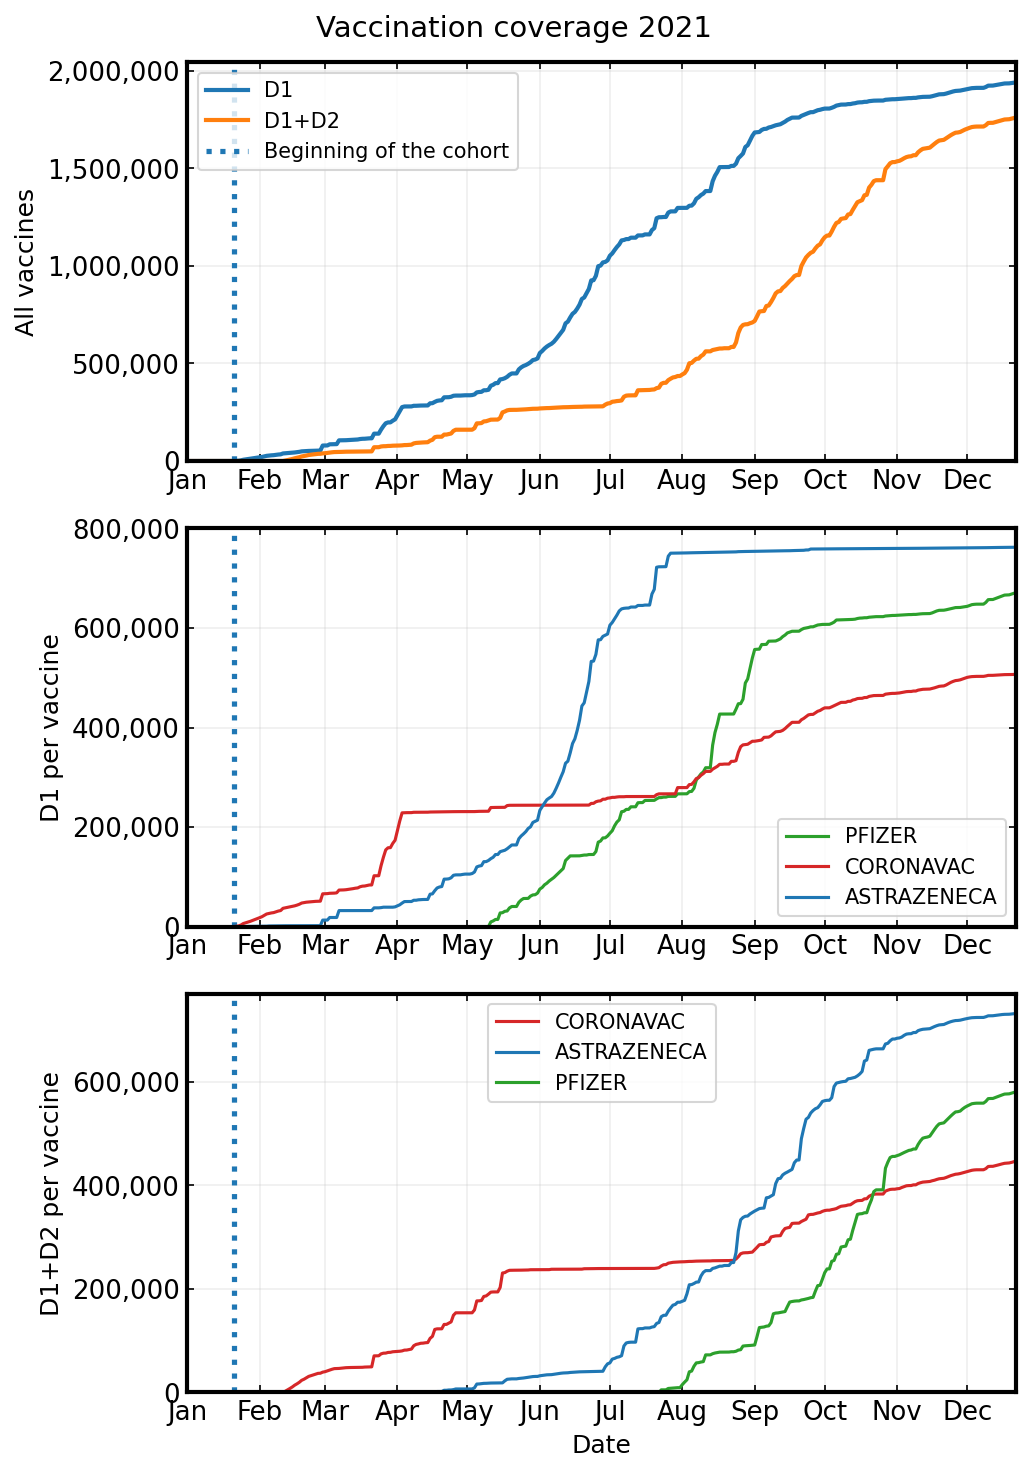

In [146]:
Image(filename=os.path.join(fig_pres, 'vaccine_coverage_2021.png'), width=700) 

## **Outcomes 2021**

1. Death by Covid-19<br>
2. Admission to ICU due to Covid-19<br>
3. Hospitalization due to Covid-19<br>

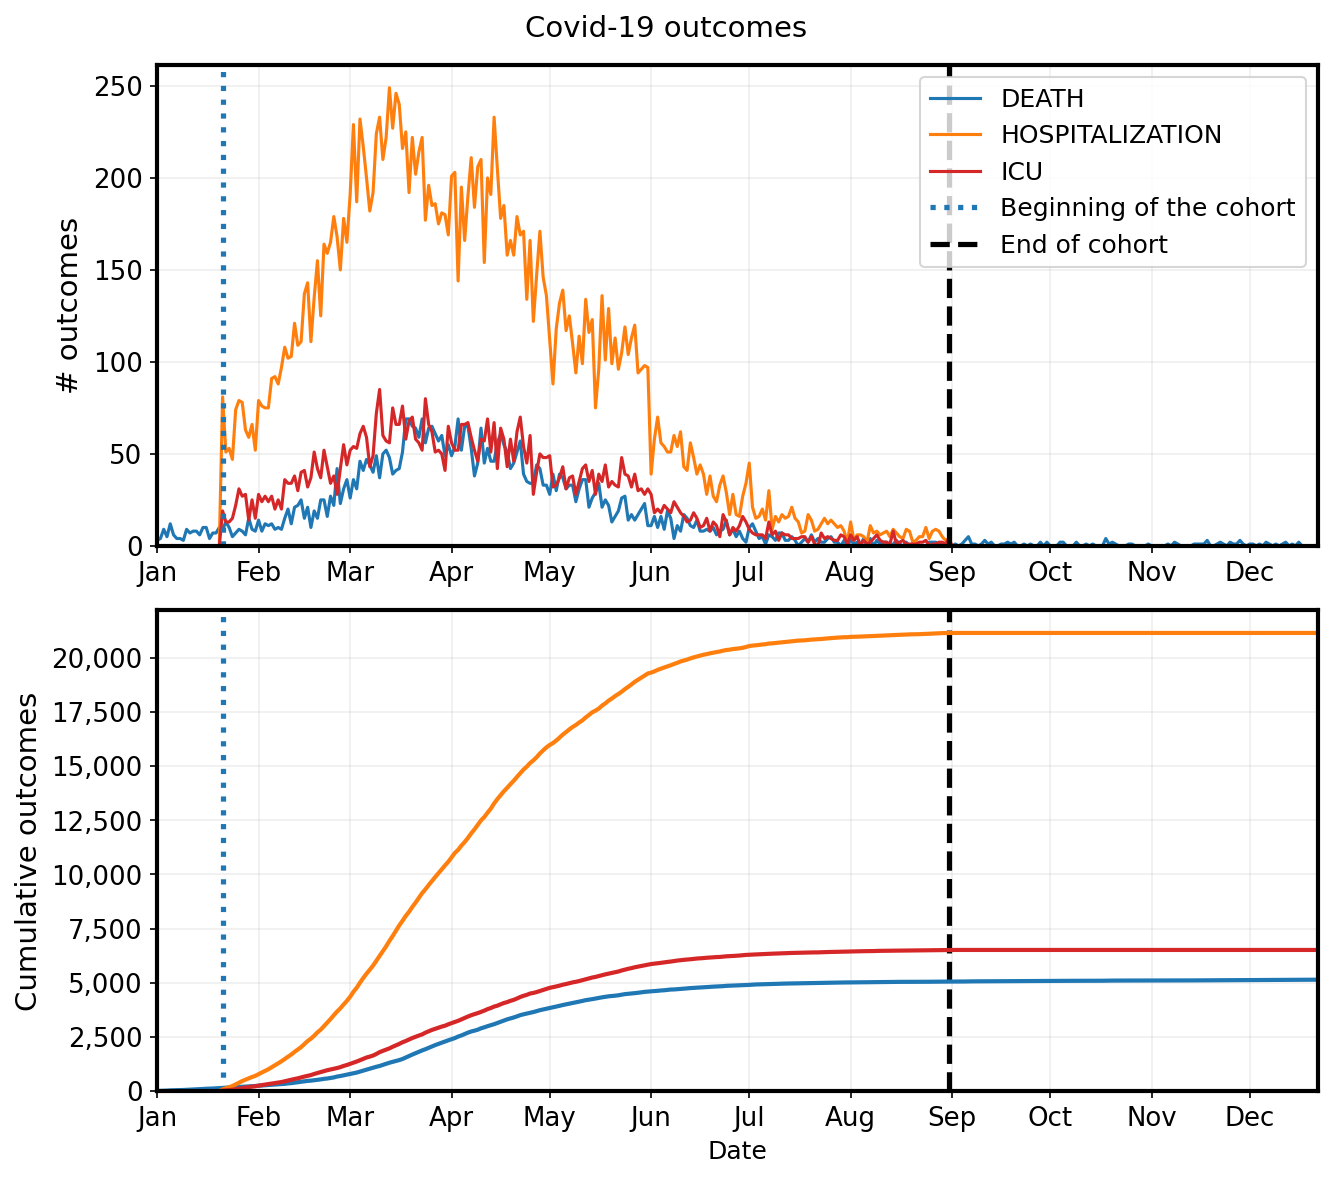

In [156]:
Image(filename=os.path.join(fig_pres, 'outcomes_2021.png'), width=800)

 ## **LINKAGE**

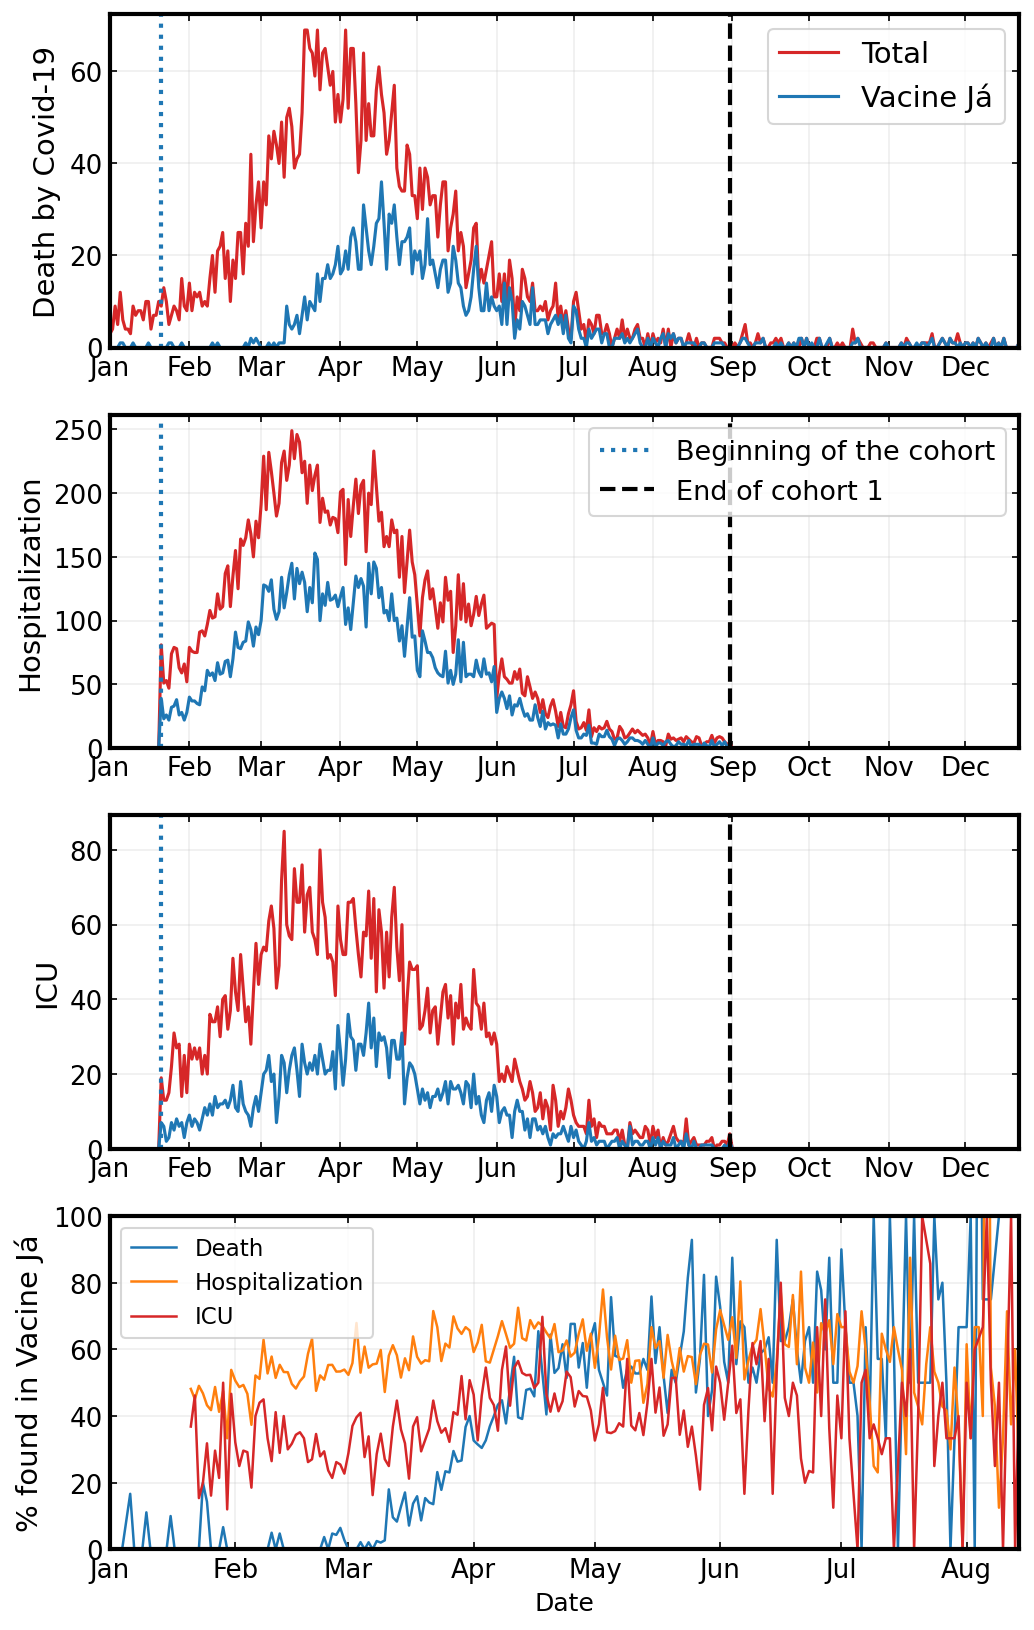

In [157]:
Image(filename=os.path.join(fig_pres, 'vacineja_outcomes_linkage_2021.png'), width=800)

## **Matching**

### **Method**

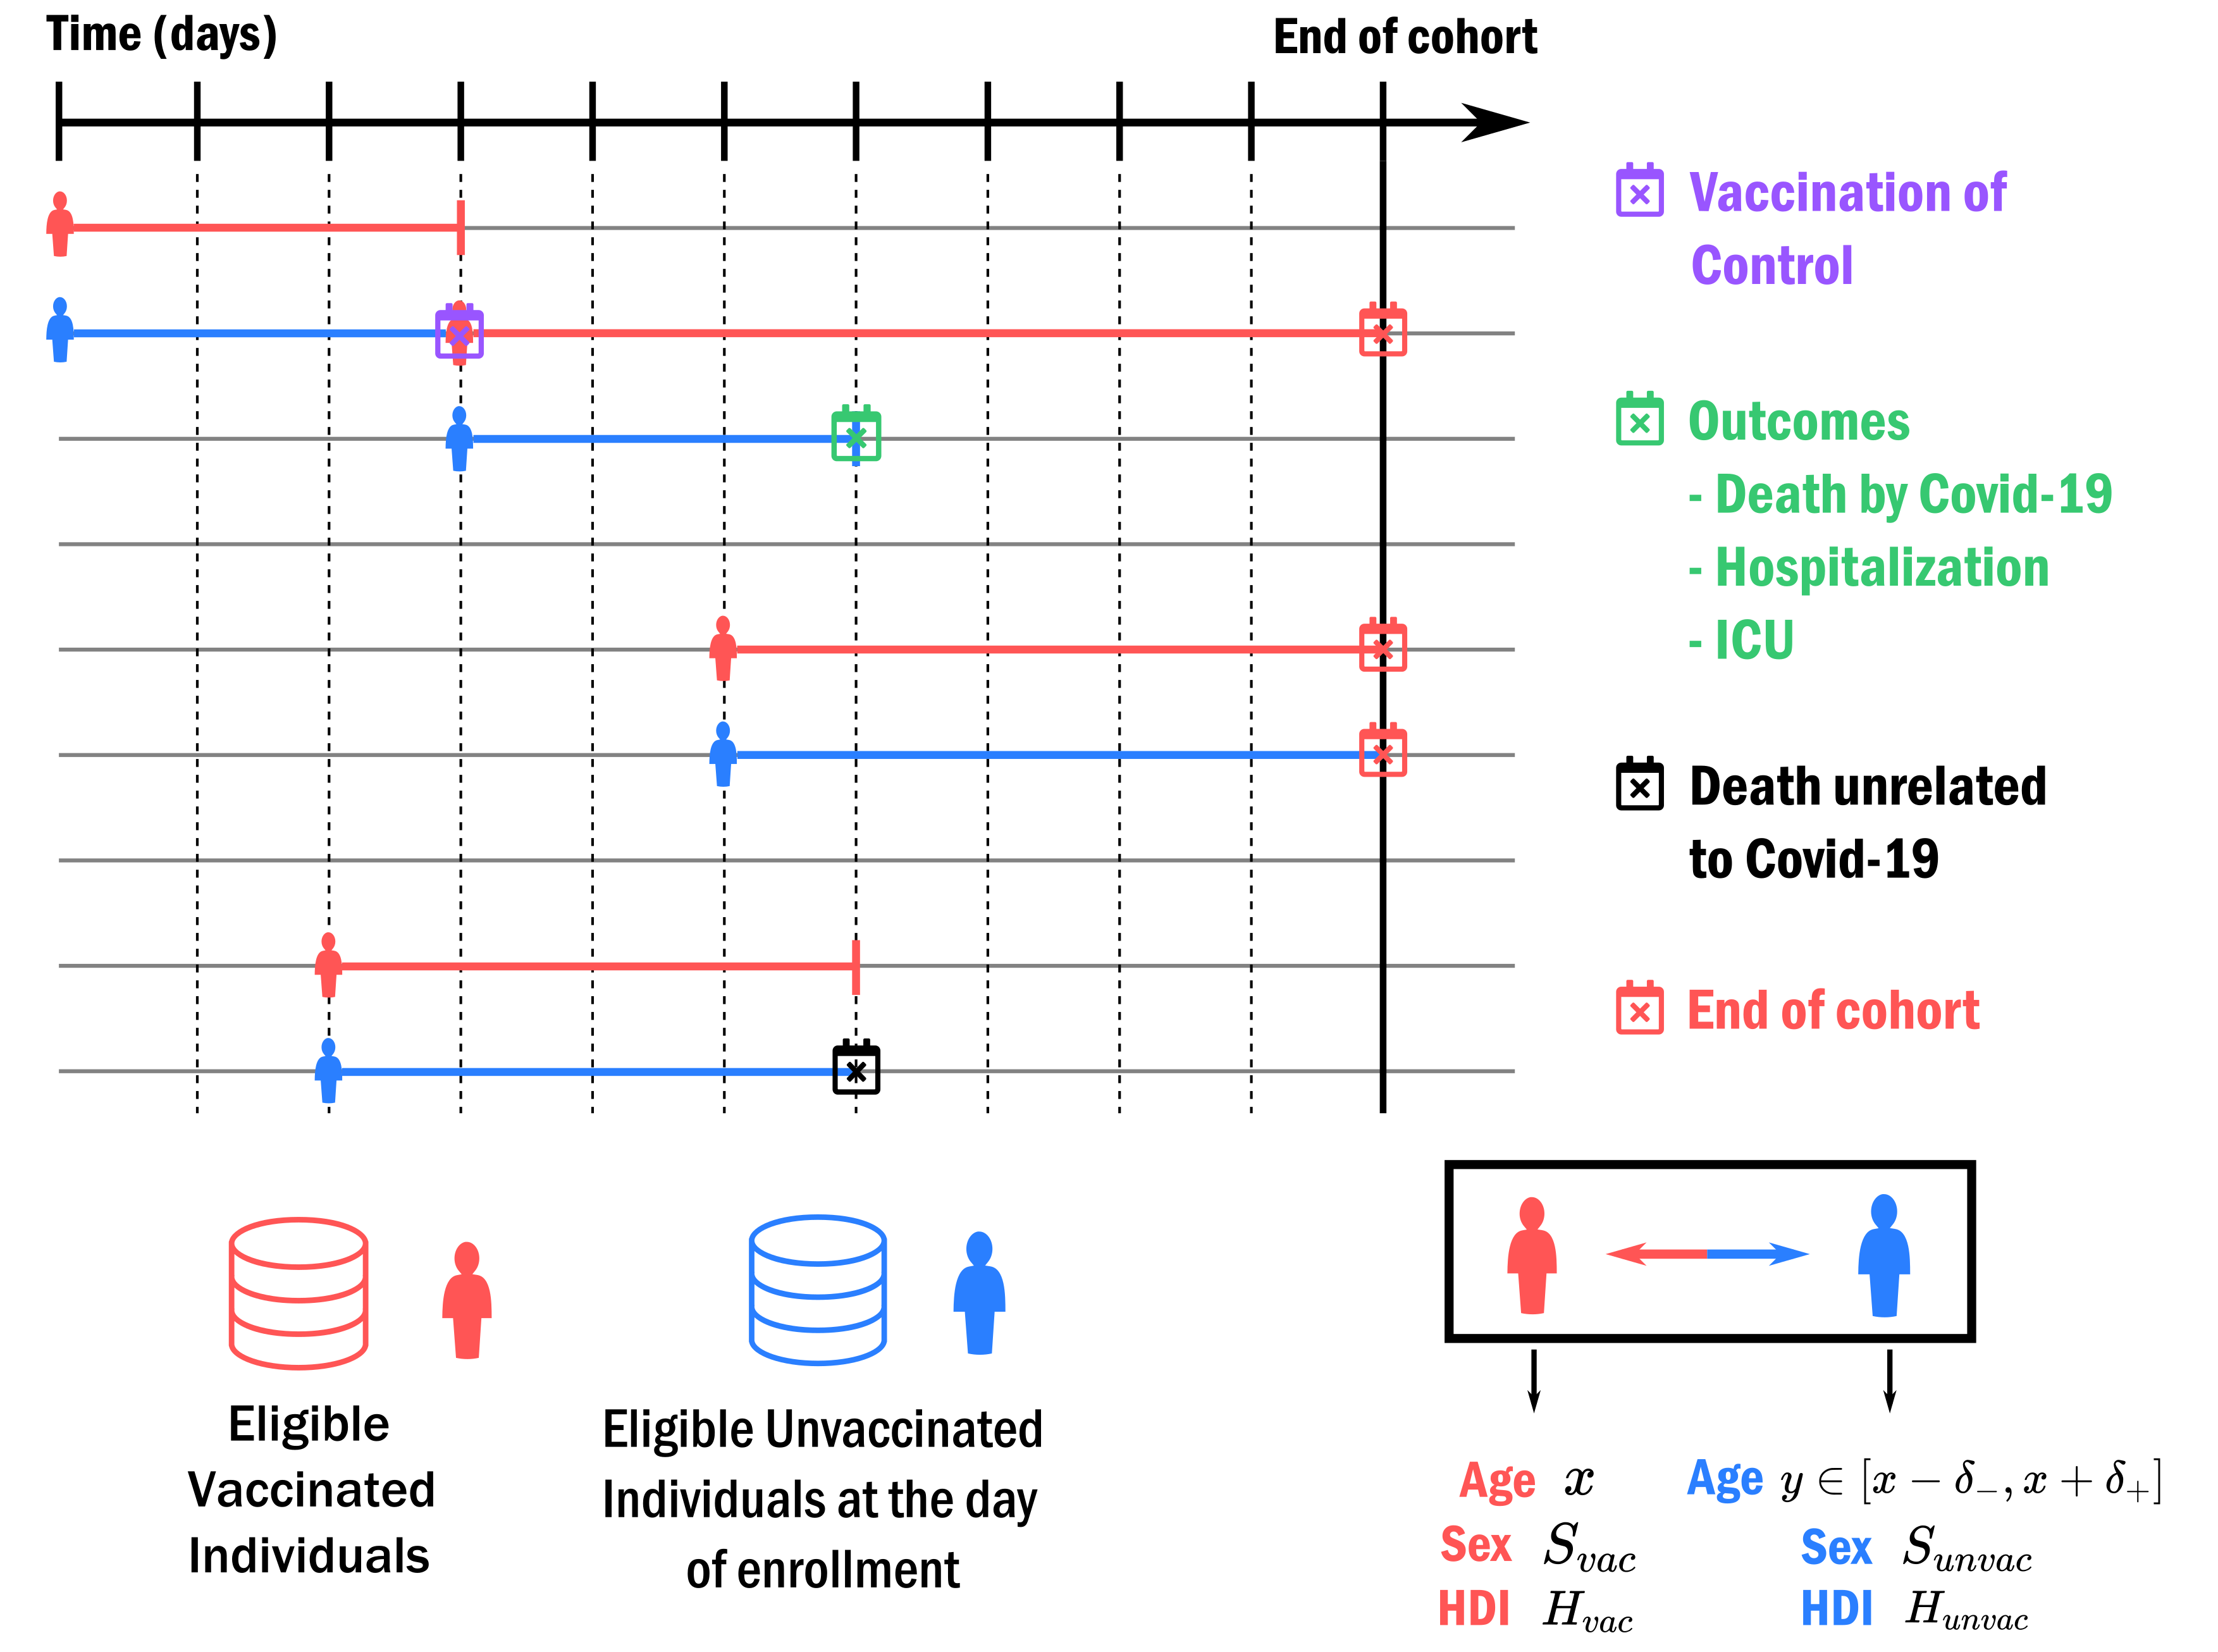

In [158]:
Image(filename=os.path.join(fig_pres, 'matching3.png'), width=900)

### **Cohort and matching numbers (D1)**

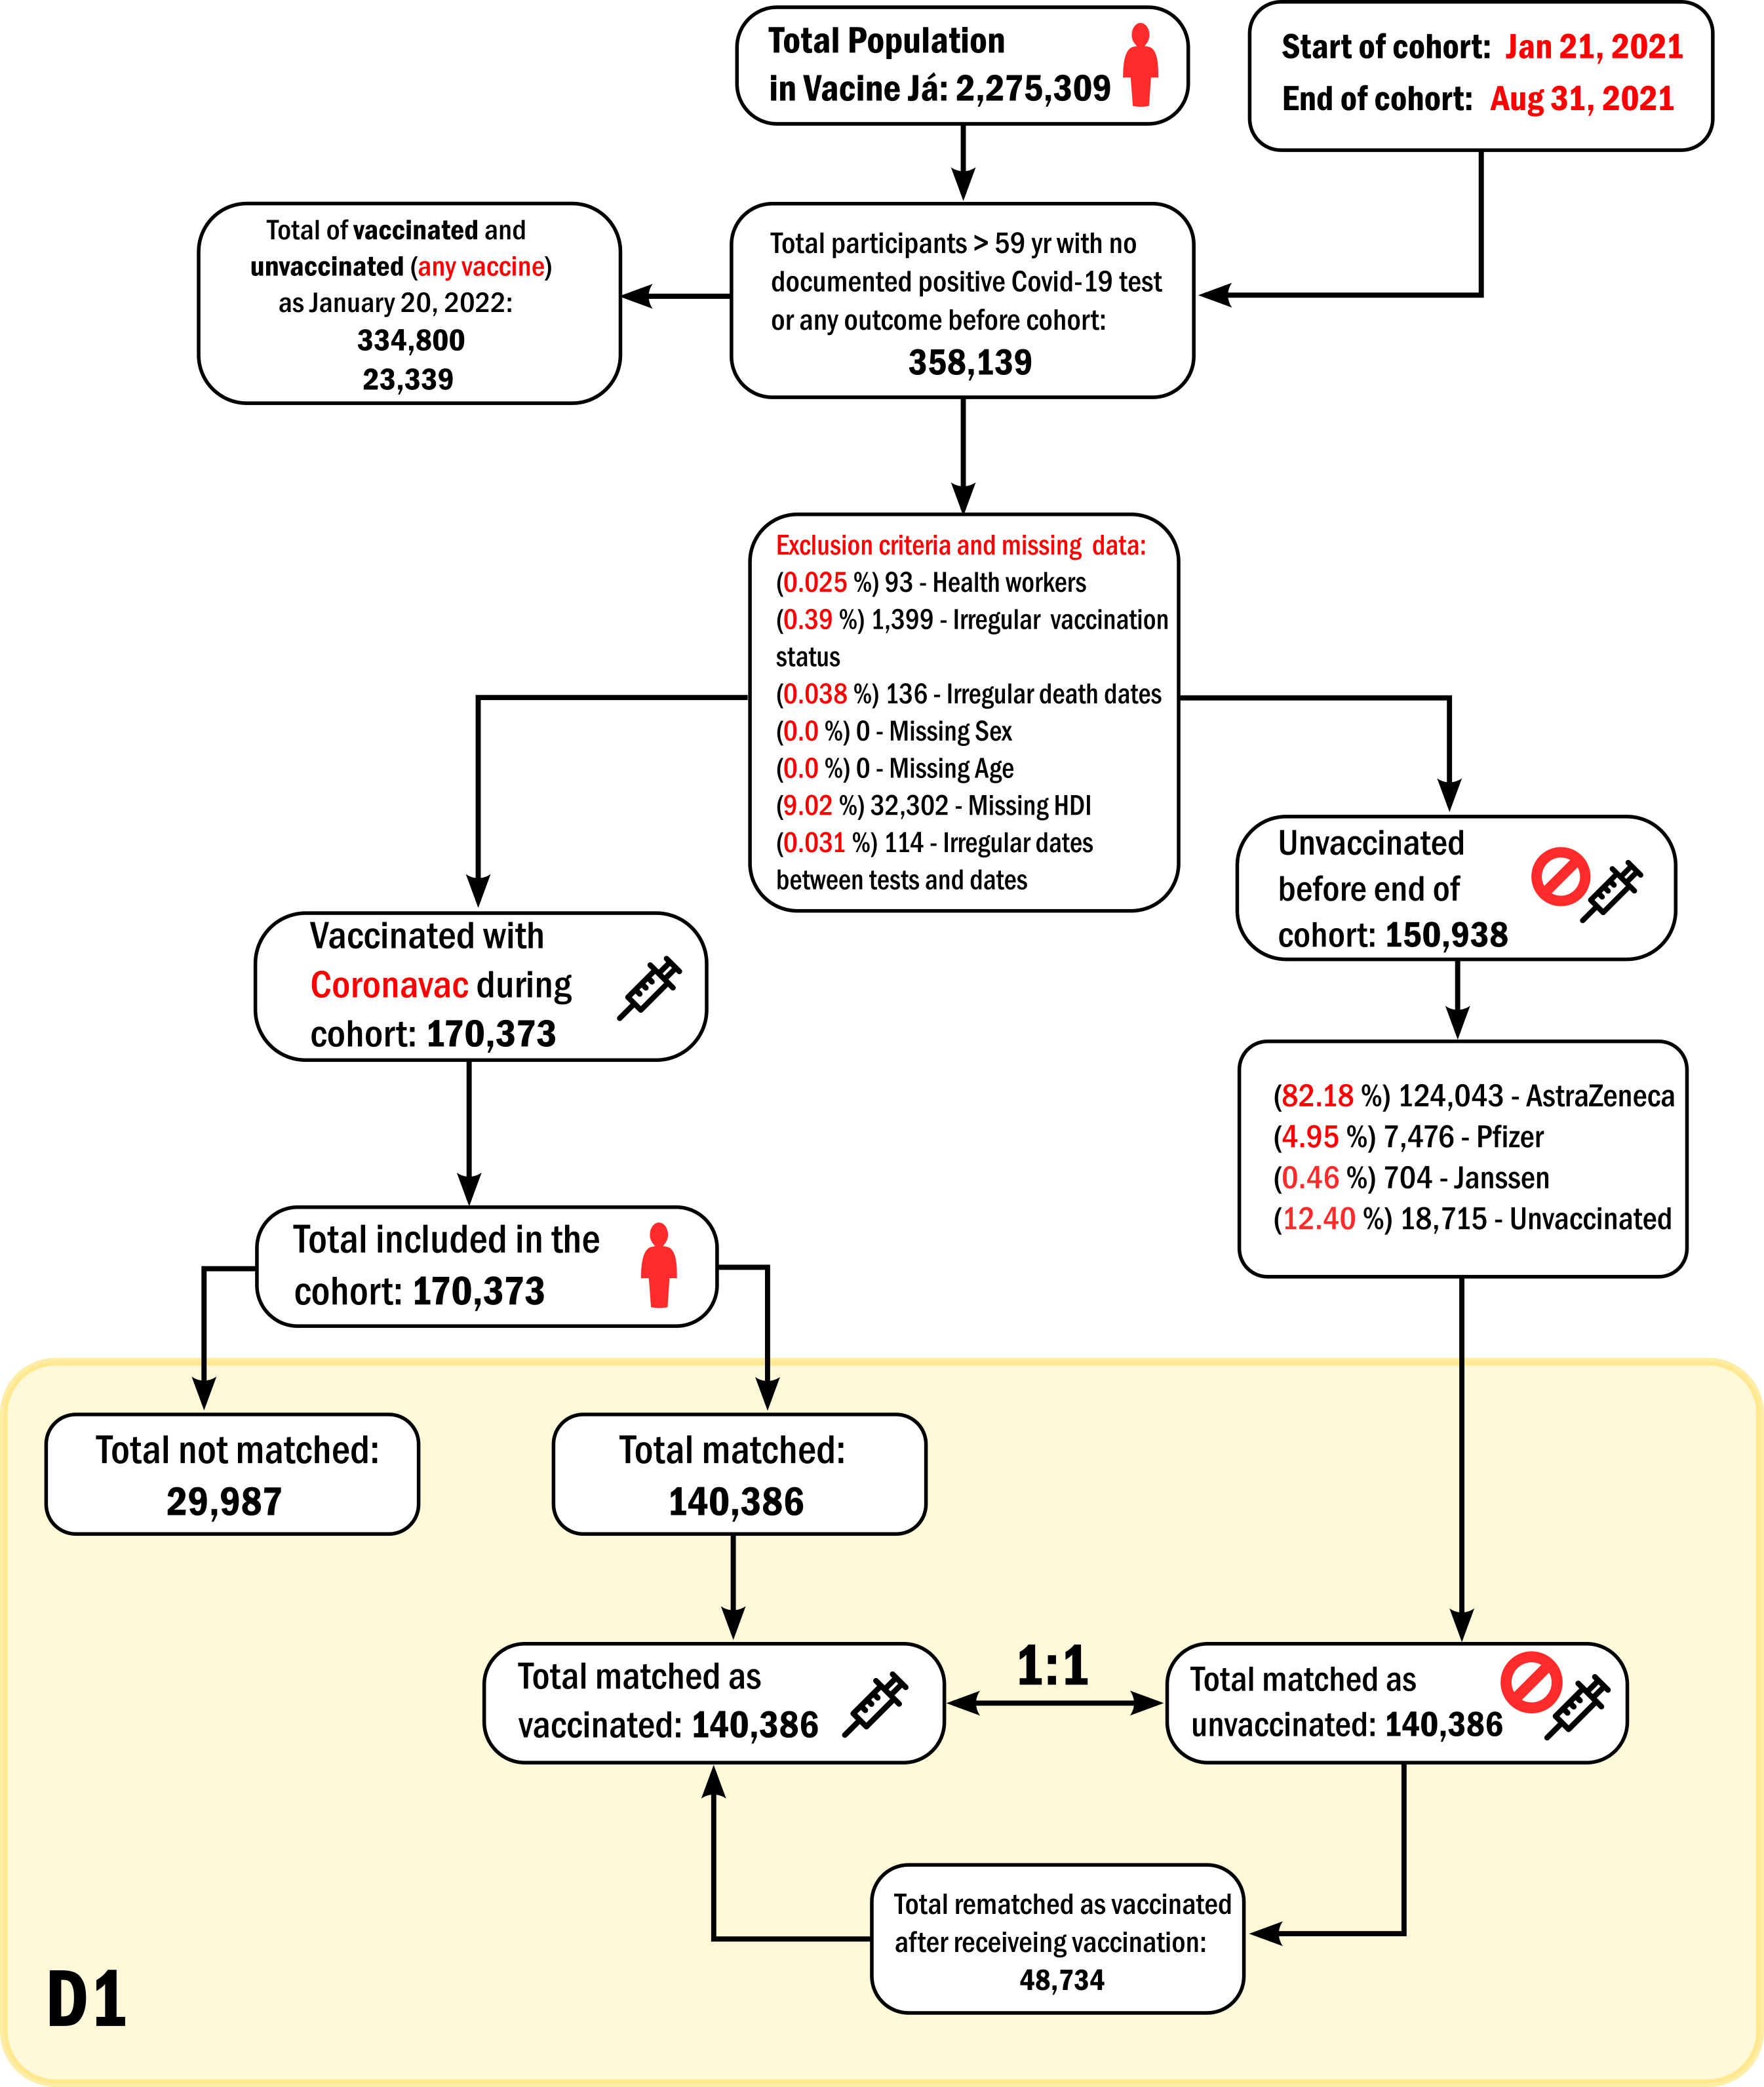

In [170]:
Image(filename=os.path.join(fig_pres, 'coronavac_cohort_diagram_d1.png'), width=800)

**Population proportions**

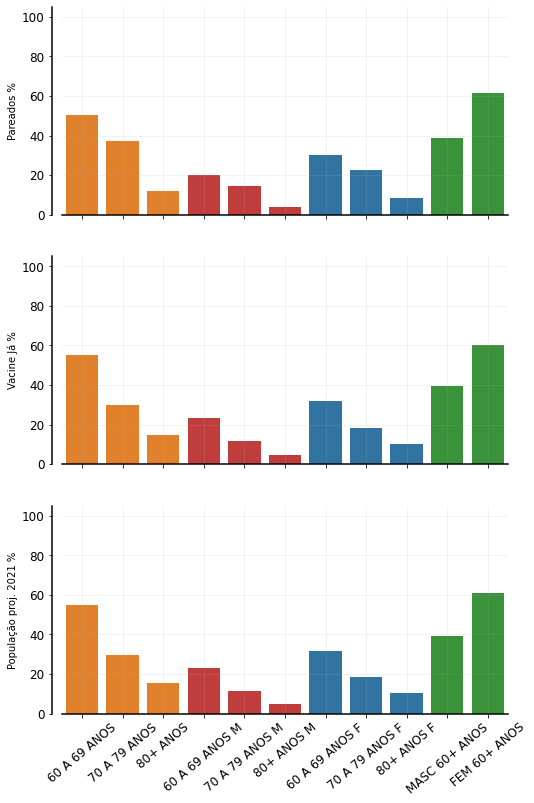

In [171]:
fig = pplot(fschema, pop2021, "CORONAVAC", "NOVO", hdi_index=2, dose="D1", cohort_str="21JAN2021_31AUG2021", day_risk=0, seed=1)

**HDI**

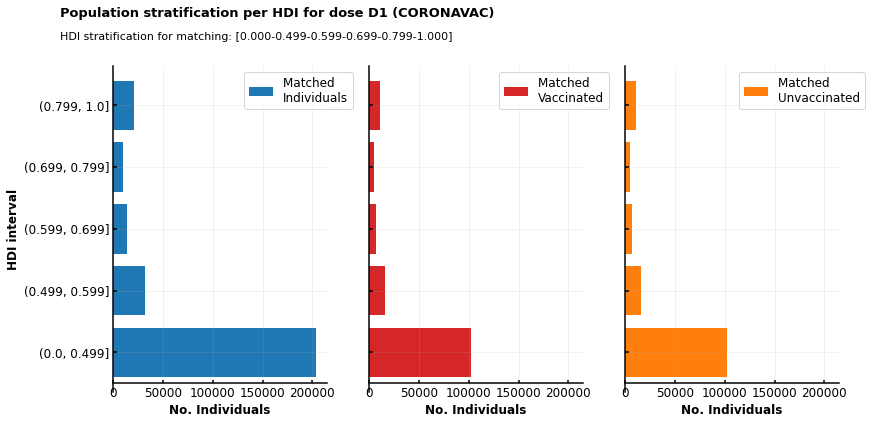

In [172]:
inter = [0.000,0.499,0.599, 0.699, 0.799, 1.000]
#inter = [0.0, 0.25, 0.35, 0.5, 1.0]
#inter = None
pdf = pop_per_hdi(fschema, "CORONAVAC", "NOVO", hdi_index=2, dose="D1", cohort_str="21JAN2021_31AUG2021", day_risk=0, seed=1, inter=inter)

#### **table**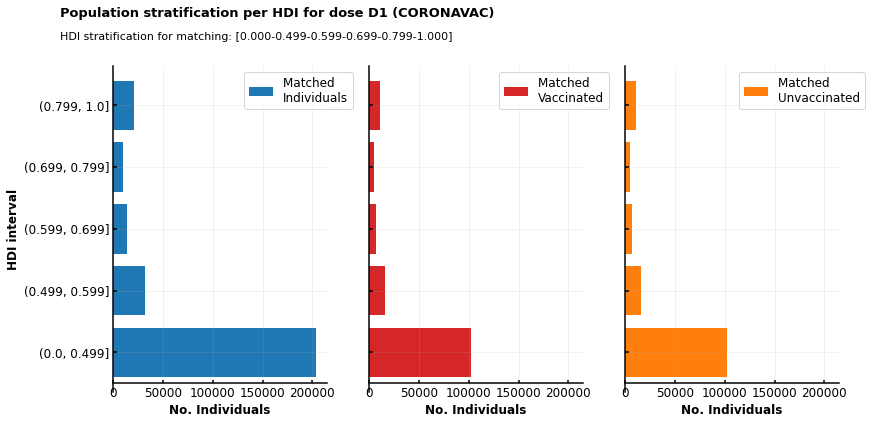

In [164]:
proportions(fschema, pop2021, "CORONAVAC", "NOVO", hdi_index=2, dose="D1", cohort_str="21JAN2021_31AUG2021", day_risk=0, seed=1)

,Pareados,Vacine Já,População proj. 2021,Pareados %,Vacine Já %,População proj. 2021 %
60 A 69 ANOS,70706,199428,143500,50.365421,55.341018,54.775801
70 A 79 ANOS,52466,108019,77750,37.372672,29.975136,29.678178
80+ ANOS,17214,52915,40742,12.261906,14.683846,15.551747
60 A 69 ANOS M,28145,83915,60101,20.048295,23.286307,22.941327
70 A 79 ANOS M,20540,41956,29559,14.631089,11.642737,11.283052
80+ ANOS M,5486,16585,13257,3.907797,4.602317,5.060368
60 A 69 ANOS F,42561,115513,83403,30.317126,32.054712,31.836001
70 A 79 ANOS F,31926,66063,48184,22.741584,18.332399,18.392454
80+ ANOS F,11728,36330,27473,8.354109,10.081529,10.486798
MASC 60+ ANOS,54171.0,142456.0,102917.0,38.587181,39.53136,39.284746


### **Cohort and matching numbers (D2)**

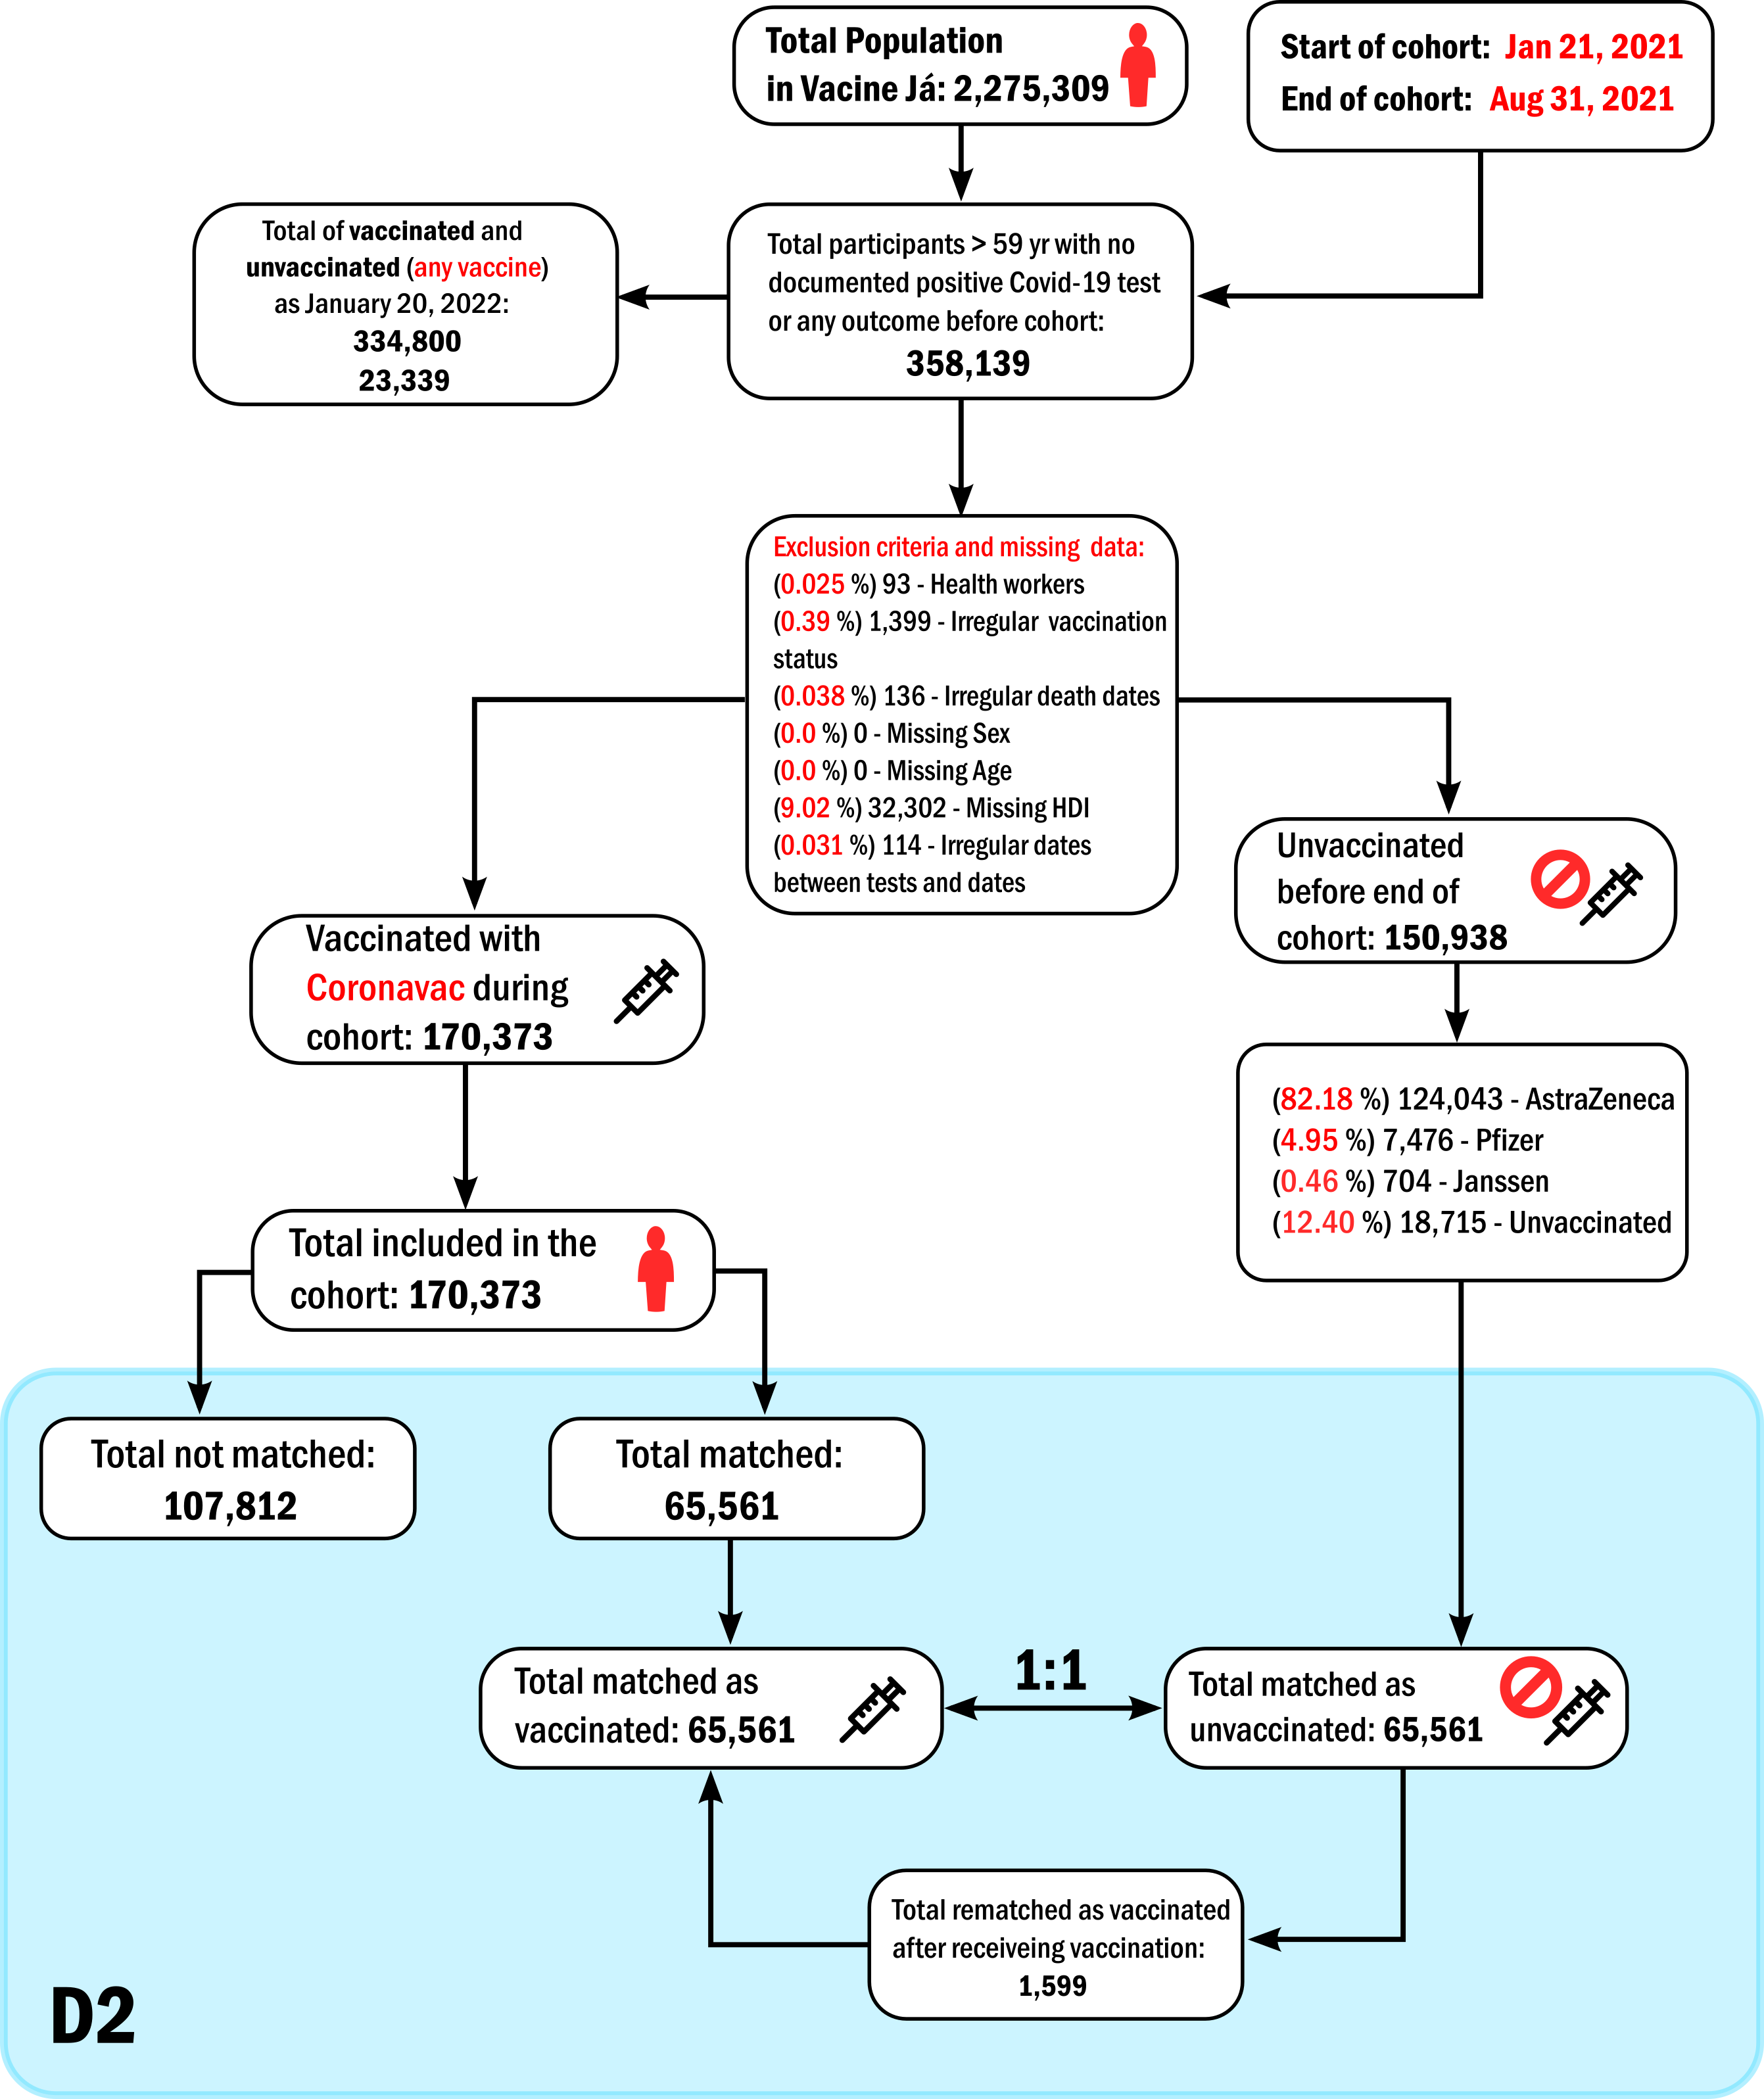

In [173]:
Image(filename=os.path.join(fig_pres, 'coronavac_cohort_diagram_d2.png'), width=900)

**Population proportions**

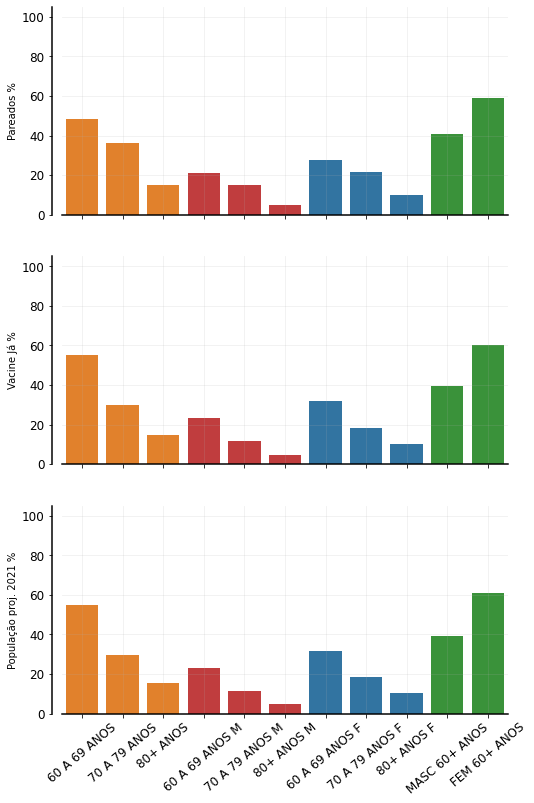

In [174]:
fig = pplot(fschema, pop2021, "CORONAVAC", "NOVO", hdi_index=2, dose="D2", cohort_str="21JAN2021_31AUG2021", day_risk=14, seed=1)

**HDI**

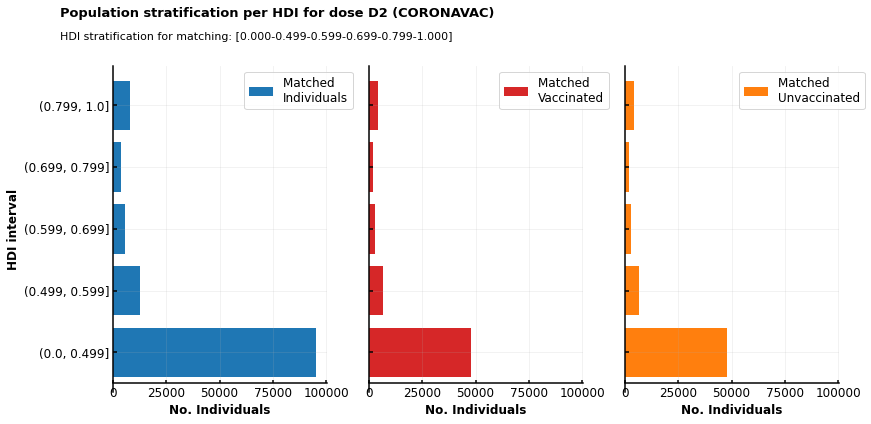

In [175]:
inter = [0.000,0.499,0.599, 0.699, 0.799, 1.000]
#inter = [0.0, 0.25, 0.35, 0.5, 1.0]
#inter = None
pdf = pop_per_hdi(fschema, "CORONAVAC", "NOVO", hdi_index=2, dose="D2", cohort_str="21JAN2021_31AUG2021", day_risk=14, seed=1, inter=inter)

#### **table**

In [166]:
proportions(fschema, pop2021, "CORONAVAC", "NOVO", hdi_index=2, dose="D2", cohort_str="21JAN2021_31AUG2021", day_risk=14, seed=1)

,Pareados,Vacine Já,População proj. 2021,Pareados %,Vacine Já %,População proj. 2021 %
60 A 69 ANOS,30421,199428,143500,48.626141,55.341018,54.775801
70 A 79 ANOS,22753,108019,77750,36.369304,29.975136,29.678178
80+ ANOS,9387,52915,40742,15.004556,14.683846,15.551747
60 A 69 ANOS M,13219,83915,60101,21.129777,23.286307,22.941327
70 A 79 ANOS M,9275,41956,29559,14.82553,11.642737,11.283052
80+ ANOS M,3127,16585,13257,4.998322,4.602317,5.060368
60 A 69 ANOS F,17202,115513,83403,27.496364,32.054712,31.836001
70 A 79 ANOS F,13478,66063,48184,21.543773,18.332399,18.392454
80+ ANOS F,6260,36330,27473,10.006234,10.081529,10.486798
MASC 60+ ANOS,25621.0,142456.0,102917.0,40.953629,39.53136,39.284746


## **Kaplan-Meier & VE**

### **Kaplan-Meier**

**D1**

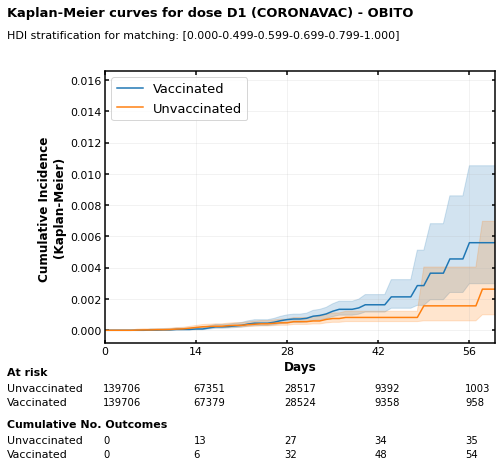

In [219]:
pprint_km_d1("CORONAVAC", "NOVO", hdi_index=2, cohort_str="21JAN2021_31AUG2021", event="OBITO", day_risk=0, seed=1, strat="KM_DOSE")

**D2**

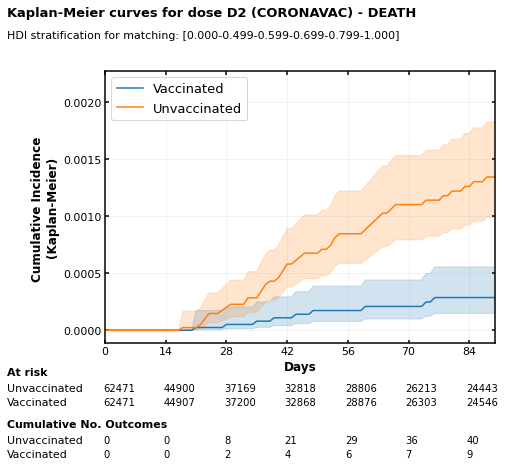

In [220]:
km_fig = pprint_km("CORONAVAC", "NOVO", hdi_index=2, dose="D2", cohort_str="21JAN2021_31AUG2021", event="OBITO", day_risk=14, seed=1, strat="KM_DOSE")

**Strat**

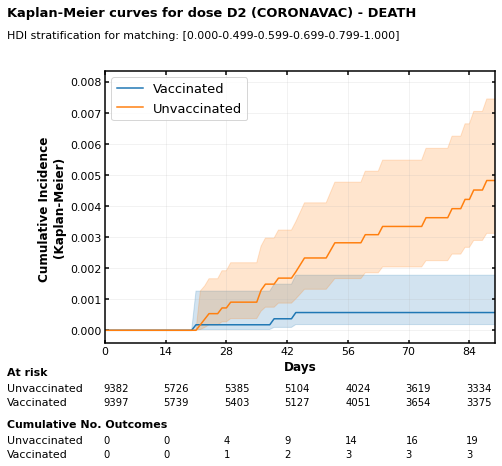

In [226]:
km_fig = pprint_km("CORONAVAC", "NOVO", hdi_index=2, dose="D2", cohort_str="21JAN2021_31AUG2021", event="OBITO", day_risk=14, seed=1, strat="KM_80+")

### **VE**

**D1**

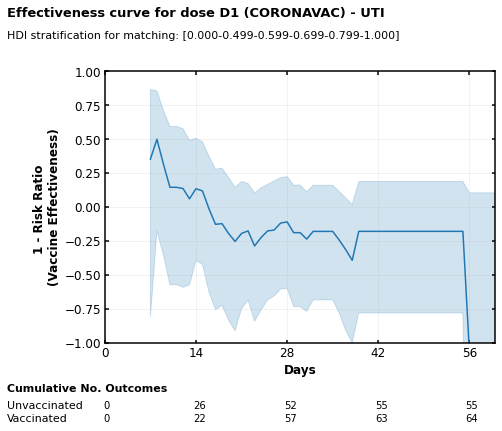

In [234]:
pprint_ve_d1("CORONAVAC", "NOVO", hdi_index=2, cohort_str="21JAN2021_31AUG2021", event="UTI", day_risk=0, seed=1, strat="DOSE", plot_days=7)

**D2**

0.8857017607906028


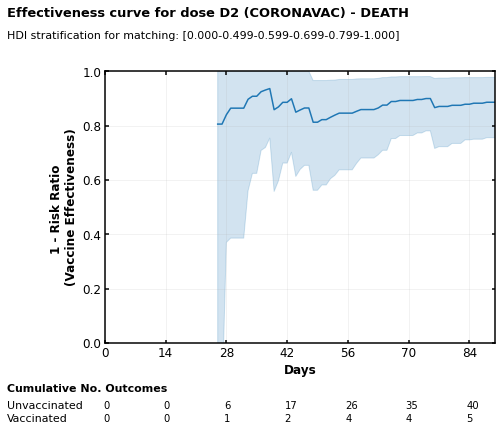

In [112]:
ve_fig = pprint_ve("CORONAVAC", "NOVO", hdi_index=2, dose="D2", cohort_str="21JAN2021_31AUG2021", event="OBITO", day_risk=14, seed=6, strat="DOSE", plot_days=12)

**Strat**

0.7724567483093384


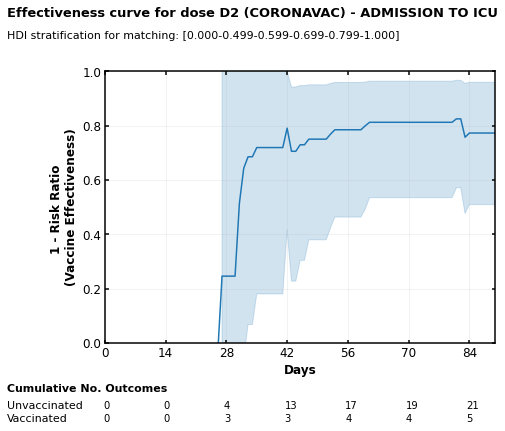

In [101]:
ve_fig = pprint_ve("CORONAVAC", "NOVO", hdi_index=2, dose="D2", cohort_str="21JAN2021_31AUG2021", event="UTI", day_risk=14, seed=1, strat="HDI_000_050", plot_days=12)

**MEAN VE**

0.8113751747376406
0.523105938505113
0.6088592276528392


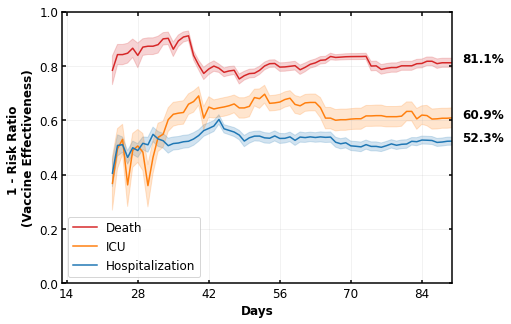

In [206]:
fig, ve_df = stats_error_ve("CORONAVAC", "NOVO", 2, "D2", "21JAN2021_31AUG2021", "OBITO", 14)

In [207]:
ve_df

,t,VE_original,VE_original,VE_original,VE_original,VE_original,VE_original,VE_original,VE_original,VE_original,VE_original,VE_mean,std,SE,VE_mean_lower,VE_mean_upper,VE_mean_lower_std,VE_mean_upper_std
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,196,0.815085,0.88074,0.848237,0.814127,0.774856,0.827371,0.820508,0.840866,0.754741,0.853355,0.822989,0.037051,0.011717,0.811272,0.834705,0.804463,0.841514
197,197,0.815085,0.88074,0.848237,0.814127,0.774856,0.827371,0.820508,0.840866,0.754741,0.853355,0.822989,0.037051,0.011717,0.811272,0.834705,0.804463,0.841514
198,198,0.815085,0.88074,0.848237,0.814127,0.774856,0.827371,0.820508,0.840866,NaN,0.853355,0.830572,0.029958,0.009986,0.820586,0.840558,0.815593,0.845551
199,199,NaN,NaN,0.848237,0.814127,NaN,0.827371,0.820508,0.840866,NaN,0.853355,0.834077,0.015782,0.006443,0.827635,0.840520,0.826187,0.841968


HOSPITAL
0.523105938505113


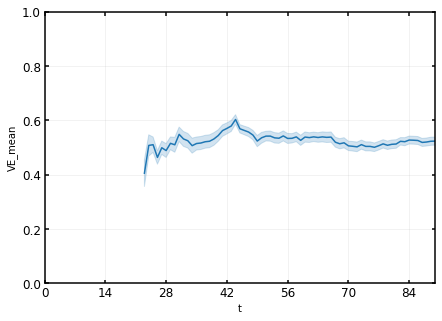

In [136]:
fig, ve_df = stats_error_ve("CORONAVAC", "NOVO", 2, "D2", "21JAN2021_31AUG2021", "HOSPITAL", 14, figs=fig)

In [ ]:
cond_age = fschema["IDADE"]>=60
pprint_ve("CORONAVAC", "NOVO", hdi_index=2, dose="D2", cohort_str="21JAN2021_31AUG2021", event="UTI", day_risk=14, seed=1, strat="DOSE", plot_days=12)

In [235]:
pairs_df = get_pairs("CORONAVAC", "NOVO", hdi_index=2, dose="D1", cohort_str="21JAN2021_31AUG2021", day_risk=0, seed=1)

In [253]:
all_individuals = np.unique([ x for x in pairs_df["CPF CASO"].tolist()+pairs_df["CPF CONTROLE"].tolist() if x is not None ])

In [255]:
cohort_pop = fschema[fschema["CPF"].isin(all_individuals)]

In [260]:
cohort_pop["D1_D2_interval"] = cohort_pop[["DATA D1", "DATA D2"]].apply(lambda x: (x["DATA D2"]-x["DATA D1"]).days, axis=1)

In [266]:
cohort_pop["D1_D2_interval"].array

<PandasArray>
[75.0, 89.0, 90.0, 76.0, 60.0, 63.0,  3.0, 15.0, 65.0, 64.0,
 ...
  nan,  nan,  nan,  nan,  0.0,  nan,  nan,  0.0,  nan,  nan]
Length: 232037, dtype: float64

(209572,)
(200421,)
37.08471168190958 33.0 23.88769243421172


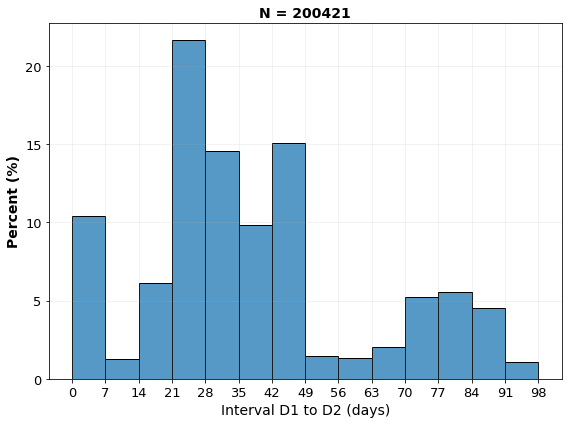

In [332]:
hist_arr = cohort_pop[cohort_pop['D1_D2_interval']>=0]['D1_D2_interval'].array
print(hist_arr.shape)
lower_perc = np.percentile(hist_arr, 5)
upper_perc = np.percentile(hist_arr, 95)
hist_arr = hist_arr[np.logical_and(hist_arr>=lower_perc,  hist_arr<=upper_perc)]
print(hist_arr.shape)
bins=np.arange(0, 100, 7)

mean = np.mean(hist_arr)
median = np.median(hist_arr)
std = np.std(hist_arr)
print(mean, median, std)

fig, ax = plt.subplots(1, figsize=(8,6))
s = sns.histplot(data=hist_arr, bins=bins, ax=ax, stat='percent')
ax.grid(alpha=0.2)
ax.set_xlabel("Interval D1 to D2 (days)", fontsize=14)
ax.set_ylabel("Percent (%)", weight='bold', fontsize=14)
ax.tick_params(labelsize=13)
ax.set_title(f"N = {hist_arr.shape[0]}", fontsize=14, weight='bold')
ax.set_xticks(bins)
#ax.text(77, 20, f"Mean = {mean}")
#ax.text(77, 20, f"Median = {mean}")
plt.tight_layout()
#fig.savefig(os.path.join(fig_pres, "interval_d1_d2_matched.jpg"), dpi=150, bbox_inches='tight')

In [330]:
size = hist_arr[np.logical_and(hist_arr>=0, hist_arr<=56)].shape[0]

In [331]:
size/200421

0.8050004740022253

0.7736224683286153


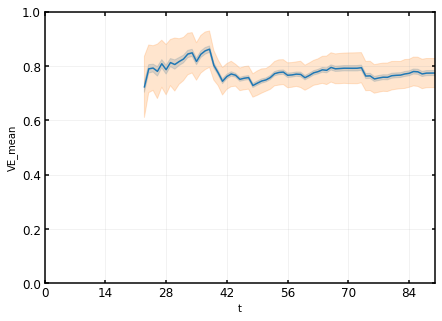

In [96]:
fig, df = stats_error_ve("CORONAVAC", "NOVO", 2, "D2", "21JAN2021_31AUG2021", "UTI", 14)

In [100]:
df[-40:]

,t,VE_original,VE_original,VE_original,VE_original,VE_original,VE_original,VE_original,VE_original,VE_original,...,VE_original,VE_original,VE_original,VE_mean,std,SE,VE_mean_lower,VE_mean_upper,VE_mean_lower_std,VE_mean_upper_std
161,161,0.815085,0.88074,0.848237,0.814127,0.774856,0.827371,0.820508,0.840866,0.754741,...,0.478263,0.412725,0.609108,0.779284,0.112307,0.009850,0.769434,0.789134,0.723130,0.835438
162,162,0.815085,0.88074,0.848237,0.814127,0.774856,0.827371,0.820508,0.840866,0.754741,...,0.478263,0.412725,0.609108,0.779284,0.112307,0.009850,0.769434,0.789134,0.723130,0.835438
163,163,0.815085,0.88074,0.848237,0.814127,0.774856,0.827371,0.820508,0.840866,0.754741,...,0.478263,0.412725,0.609108,0.779284,0.112307,0.009850,0.769434,0.789134,0.723130,0.835438
164,164,0.815085,0.88074,0.848237,0.814127,0.774856,0.827371,0.820508,0.840866,0.754741,...,0.478263,0.412725,0.609108,0.779284,0.112307,0.009850,0.769434,0.789134,0.723130,0.835438
165,165,0.815085,0.88074,0.848237,0.814127,0.774856,0.827371,0.820508,0.840866,0.754741,...,0.478263,0.412725,0.609108,0.779284,0.112307,0.009850,0.769434,0.789134,0.723130,0.835438
166,166,0.815085,0.88074,0.848237,0.814127,0.774856,0.827371,0.820508,0.840866,0.754741,...,0.478263,0.412725,0.609108,0.779284,0.112307,0.009850,0.769434,0.789134,0.723130,0.835438
167,167,0.815085,0.88074,0.848237,0.814127,0.774856,0.827371,0.820508,0.840866,0.754741,...,0.478263,0.412725,0.609108,0.779284,0.112307,0.009850,0.769434,0.789134,0.723130,0.835438
168,168,0.815085,0.88074,0.848237,0.814127,0.774856,0.827371,0.820508,0.840866,0.754741,...,0.478263,0.412725,0.609108,0.779284,0.112307,0.009850,0.769434,0.789134,0.723130,0.835438
169,169,0.815085,0.88074,0.848237,0.814127,0.774856,0.827371,0.820508,0.840866,0.754741,...,0.478263,0.412725,0.609108,0.779284,0.112307,0.009850,0.769434,0.789134,0.723130,0.835438
170,170,0.815085,0.88074,0.848237,0.814127,0.774856,0.827371,0.820508,0.840866,0.754741,...,0.478263,0.412725,0.609108,0.779284,0.112307,0.009850,0.769434,0.789134,0.723130,0.835438


In [115]:
open_ve("CORONAVAC", "NOVO", 2, "D2", "21JAN2021_31AUG2021", "OBITO", 14, 1, strat=f"DOSE")

,t,VE_lower_0.95,VE,VE_upper_0.95,VE_original
0,0,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN
...,...,...,...,...,...
194,196,0.658518,0.81389,0.930464,0.815085
195,197,0.658518,0.81389,0.930464,0.815085
196,198,0.658518,0.81389,0.930464,0.815085
197,199,0.658518,0.81389,0.930464,NaN


In [116]:
open_ve("CORONAVAC", "NOVO", 2, "D2", "21JAN2021_31AUG2021", "UTI", 14, 1, strat=f"DOSE")

,t,VE_lower_0.95,VE,VE_upper_0.95,VE_original
0,0,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN
...,...,...,...,...,...
194,196,0.383861,0.657623,0.863605,0.660628
195,197,0.383861,0.657623,0.863605,0.660628
196,198,0.383861,0.657623,0.863605,0.660628
197,199,0.383861,0.657623,0.863605,NaN
